## Online portfolio optimization under CV@R constraint using stochastic mirror descent

In [1]:
# Simulation tools
import numpy as np
import pylab as pl
import sys
import matplotlib.pyplot as plt
%matplotlib notebook

Latex commands

$\newcommand{\Var}{\operatorname{Var}}$
$\newcommand{\im}{\operatorname{im}}$

### I - Problem

#### 1 - Initial problem

We have $m$ assets numbered from $1$ to $m$, and we define $A_i(t)$ to be the price of asset $i$ at time $t$.

With that being said, we then define the return vector $Z$ of the assets at a fixed time in the horizon $T$ is given by:

$$
Z_i := \frac{A_i(T)}{A_i(0)} - 1.
$$

An <b>investment strategy</b> is a vector of positive weights $u = (u_1,\dots,u_m)$; $u_i > 0$ s.t. $\sum_{i=1}^{m}u_i = 1$, i.e.

$$
u \in \Delta_m := \big\{ u \in \mathbb{R}_+^m: \sum_{i=1}^m u_i = 1 \big\}.
$$

We want to optimize the return of our strategy, given by

$$
\langle Z,u\rangle = \sum_{i=1}^{m}u_iZ_i.
$$

#### 2 - Constraint

Let $\alpha$ be a risk level. We define the following:

<ul>
    <li>
        <b>Value at risk:</b>
        $$
        V@R_\alpha(u) = \sup{\Big\{ q \in \mathbb{R}: \mathbb{P}\big(\langle Z,u\rangle \leq q\big) \leq \alpha \Big\}}.
        $$
        Intuition: this is the worst value we can get at this risk level.
    </li>
    <br>
    <li>
        <b>Conditional Value at risk:</b>
        $$
        CV@R_\alpha(u) = \mathbb{E} \big[ -\langle Z,u\rangle | \langle Z,u\rangle \leq V@R_\alpha(u) \big].
        $$
        Intuition: this is the mean value of the loss for when we get a return under the value at risk.
    </li>
</ul>

#### 3 - Formulation of the problem under constraint

For a constraint level $M$ and a risk level $\alpha$, the problem we are interested in is the following:
$$
\begin{align}
P_M &= argmax_{u \in \Delta_m} \Big\{ \sum_{i=1}^{m} u_iZ_i: CV@R_\alpha(u) \leq M \Big\} \\
&= argmax_{\begin{cases}u \in \Delta_m \\ CV@R_\alpha(u) \leq M\end{cases}} \langle Z,u\rangle \\
&= argmin_{\begin{cases}u \in \Delta_m \\ CV@R_\alpha(u) \leq M\end{cases}} -\langle Z,u\rangle.
\end{align}
$$

#### 4 - Problem reparametrization using Lagrange multipliers

The problem above can be re-written using Lagrange multipliers as:
$$
Q_\lambda = argmin_{u \in \Delta_m} \Big\{ - \sum_{i=1}^{m} u_iZ_i + \lambda CV@R_\alpha(u) \Big\},
$$
for any $\lambda > 0$.

In fact, the collection of convex problems $(P_M)_{M>0}$ and $(Q_\lambda)_{\lambda>0}$ are equivalent, that is, for any $M > 0$ for which the $P_M$ exists (feasible constraint),
$$
\exists \lambda^*_M > 0 , \quad u^*_M = argmin_{u \in \Delta_m} \Big\{ - \sum_{i=1}^{m} u_iZ_i + \lambda^*_M CV@R_\alpha(u) \Big\}.
$$

#### 5 - Formulation using convex representation of the CV@R

We have

$$
CV@R_\alpha(u) = \min_{\theta \in \mathbb{R}}{\psi_\alpha(u, \theta)},
$$

where $\psi$ is the convex <b>coercive</b> Lipschitz continuous and differentiable function defined by:

$$
\psi_\alpha(u,\theta) = \theta + \frac{1}{1-\alpha}\mathbb{E}[\lfloor \langle Z,u\rangle - \theta\rfloor_+],
$$

where $\lfloor x\rfloor_+ = \max{(0, x)}$.

Hence, our initial constrained optimization problem can be described by the convex unconstrained problem:

$$
Q_\lambda = argmin_{(u,\theta)\in\Delta_m\times\mathbb{R}} \{ p_\lambda(u,\theta) \},
$$

where the key function $p_\lambda$ is defined by:

$$
p_\lambda(u,\theta) = - \sum_{i=1}^{m} u_i\mathbb{E}[Z_i] + \lambda \psi_\alpha(\theta,u).
$$

### II - Solution

#### 1 - Possible approaches

We can approach the problem described above using a classical stochastic gradient descent to find the optimum of the return on $\mathbb{R}_+^m$ then project it on the simplex, leading to projected stochastic gradient descent (PSGD) algorithm.

However,the projection on the simplex can be tricky. In fact, it tends to favor extremal points, which makes it numerically costly when some high-dimensional portfolio are considered. As a result, projection becomes itself an additional step that slows down the convergence of algorithms. Here comes the idea of using a <b>stochastic mirror descent</b> [Nemirovski & Yudin 83]. This algorithm consists of replacing the Euclidean distance by the Bergman divergence in the second order Taylor expansion in order to avoid the costly projection on the simplex.

#### 2 - Projected Stochastic Gradient Descent (PSGD)

#### a - Gradient Descent

When looking to solve the unconstrained optimization problem:

$$
argmin_{x \in \mathbb{R}^n} f(x).
$$

Assuming $f \in C_L^1$, that is, $f$ is differentiable with an $L$-Lipschitz gradient, we get the following result:

$$
\forall(x,y)\in\mathbb{R}^n \quad |f(y)-f(x)-\langle\nabla f(x),y-x\rangle| \leq \frac{L}{2} \lVert y-x\rVert^2,
$$

then for any $x_0 \in \mathbb{R}^n$ we can define:

$$
\phi_{x_0, +}(x) =f(x_0) + \langle\nabla f(x),x-x_0\rangle + \frac{L}{2} \lVert y-x\rVert^2.
$$

We will call this the <b>surogate</b> function. It satisfies $\forall x \in \mathbb{R}^n$:

$$
f(x) \leq \phi_{x_0, +}(x),
$$

and provides a $2^{nd}$ order approximation of $f$ in the neighbourhood of $x_0$.

Our idea is to approximate, at each iteration, our objective function $f$ locally using $\phi_{x_k, +}$, and then use an explicit formula that minimizes $\phi_{x_k, +}$:

$$
\begin{align}
x_{k+1} &= argmin_{x \in \mathbb{R}^n} \phi_{x_k, +}(x)\\
&= x_k - \frac{1}{L} \nabla f(x_k).
\end{align}
$$

This corresponds to a gradient descent with constant step-size equal to $L^{-1}$. It is called the <b>Maximization-Minimization algorithm</b> and it is the optimal way of doing a gradient descent with a constant step-size [Sébastien Gadat, Optimisation for Big Data, Lecture Notes].

#### b - Sandbox

Let's start by simulating a gradient descent in $\mathbb{R}^2$ for the simple convex function:

$$
f(x) = x^TAx + \langle b, x \rangle,
$$

for given $A \in \mathcal{M}_2(\mathbb{R})$ and $b \in \mathbb{R}^2$.

Say we take:

$$
\begin{cases}
A = \begin{pmatrix} 1 & 1 \\ 1 & 2 \end{pmatrix} \\
\\
b = \begin{pmatrix} 1 \\ 2 \end{pmatrix}.
\end{cases}
$$

Then we have:

$$
\nabla f(x) = 2Ax + b,
$$

which gives:

$$
\begin{align}
\frac{\lVert \nabla f(x) - \nabla f(y) \rVert_2}{\lVert x-y \rVert_2}
&= 2\frac{\lVert A(x-y) \rVert_2}{\lVert x-y \rVert_2} \\
&\leq 2 \sigma_{max} (A),
\end{align}
$$

where $\sigma_{max}(A)$ is the largest <b>singular value</b> of $A$, i.e. the largest square root of eigenvalue of $A^*A$. We can compute it by computing $A^*A$ then computing its eigenvalues. We get

$$
\begin{align}
A^*A &= \begin{pmatrix} 1 & 1 \\ 1 & 2 \end{pmatrix}\begin{pmatrix} 1 & 1 \\ 1 & 2 \end{pmatrix} \\
&= \begin{pmatrix} 2 & 3 \\ 3 & 6 \end{pmatrix},
\end{align}
$$

and it's eigenvalues are:

$$
\begin{align}
& \quad \lambda \in \mathbb{R} \text{ is an eigenvalue of } A^*A \\
\iff & \quad \exists \begin{pmatrix}x\\y\end{pmatrix} \in \mathbb{R}^2 - \{(0,0)\} \text{ s.t. } \begin{pmatrix} 2 & 3 \\ 3 & 6 \end{pmatrix}\begin{pmatrix}x\\y\end{pmatrix} = \lambda\begin{pmatrix}x\\y\end{pmatrix} \\
\iff & \quad \begin{vmatrix} 2-\lambda & 3 \\ 3 & 6-\lambda \end{vmatrix} = 0 \\
\iff & \quad \lambda^2 - 8\lambda + 3 = 0 \\
\iff & \quad \lambda = 4 \pm \sqrt{13}. \\
\end{align}
$$

Therefore, we get

$$
\begin{align}
\sigma_{max}(A) &= \lambda_{max}(A^*A)  \\
&= 4 + \sqrt{13},
\end{align}
$$

Threfore $\forall x, y \in \mathbb{R}$ we have:

$$
\begin{align}
\frac{\lVert \nabla f(x) - \nabla f(y) \rVert_2}{\lVert x-y \rVert_2}
&\leq 2 \sigma_{max} (A) \\
&= 8 + 2\sqrt{13}.
\end{align}
$$

Hence $\nabla f$ is $L-$Lipschitz with

$$
L = 8 + 2\sqrt{13}.
$$

In [2]:
A = np.array([[1, 1],
              [1, 2]])

b = np.array([1, 2])

def F(x):
    return np.dot(x,np.dot(A,x)) + np.dot(b,x)

def GradF(x):
    return 2*np.dot(A,x) + b

L = 8 + 2*(13**0.5)

We have:

$$
\nabla f(x) = 2Ax + b,
$$

hence the minimum of $f$ is attained at:

$$
x = -\frac{1}{2} A^{-1} b = \begin{pmatrix} 0 \\ -0.5 \end{pmatrix}.
$$

In [3]:
x_star = np.array([0, -0.5])

This can also be observed graphically if we plot the function $f$:

<IPython.core.display.Javascript object>


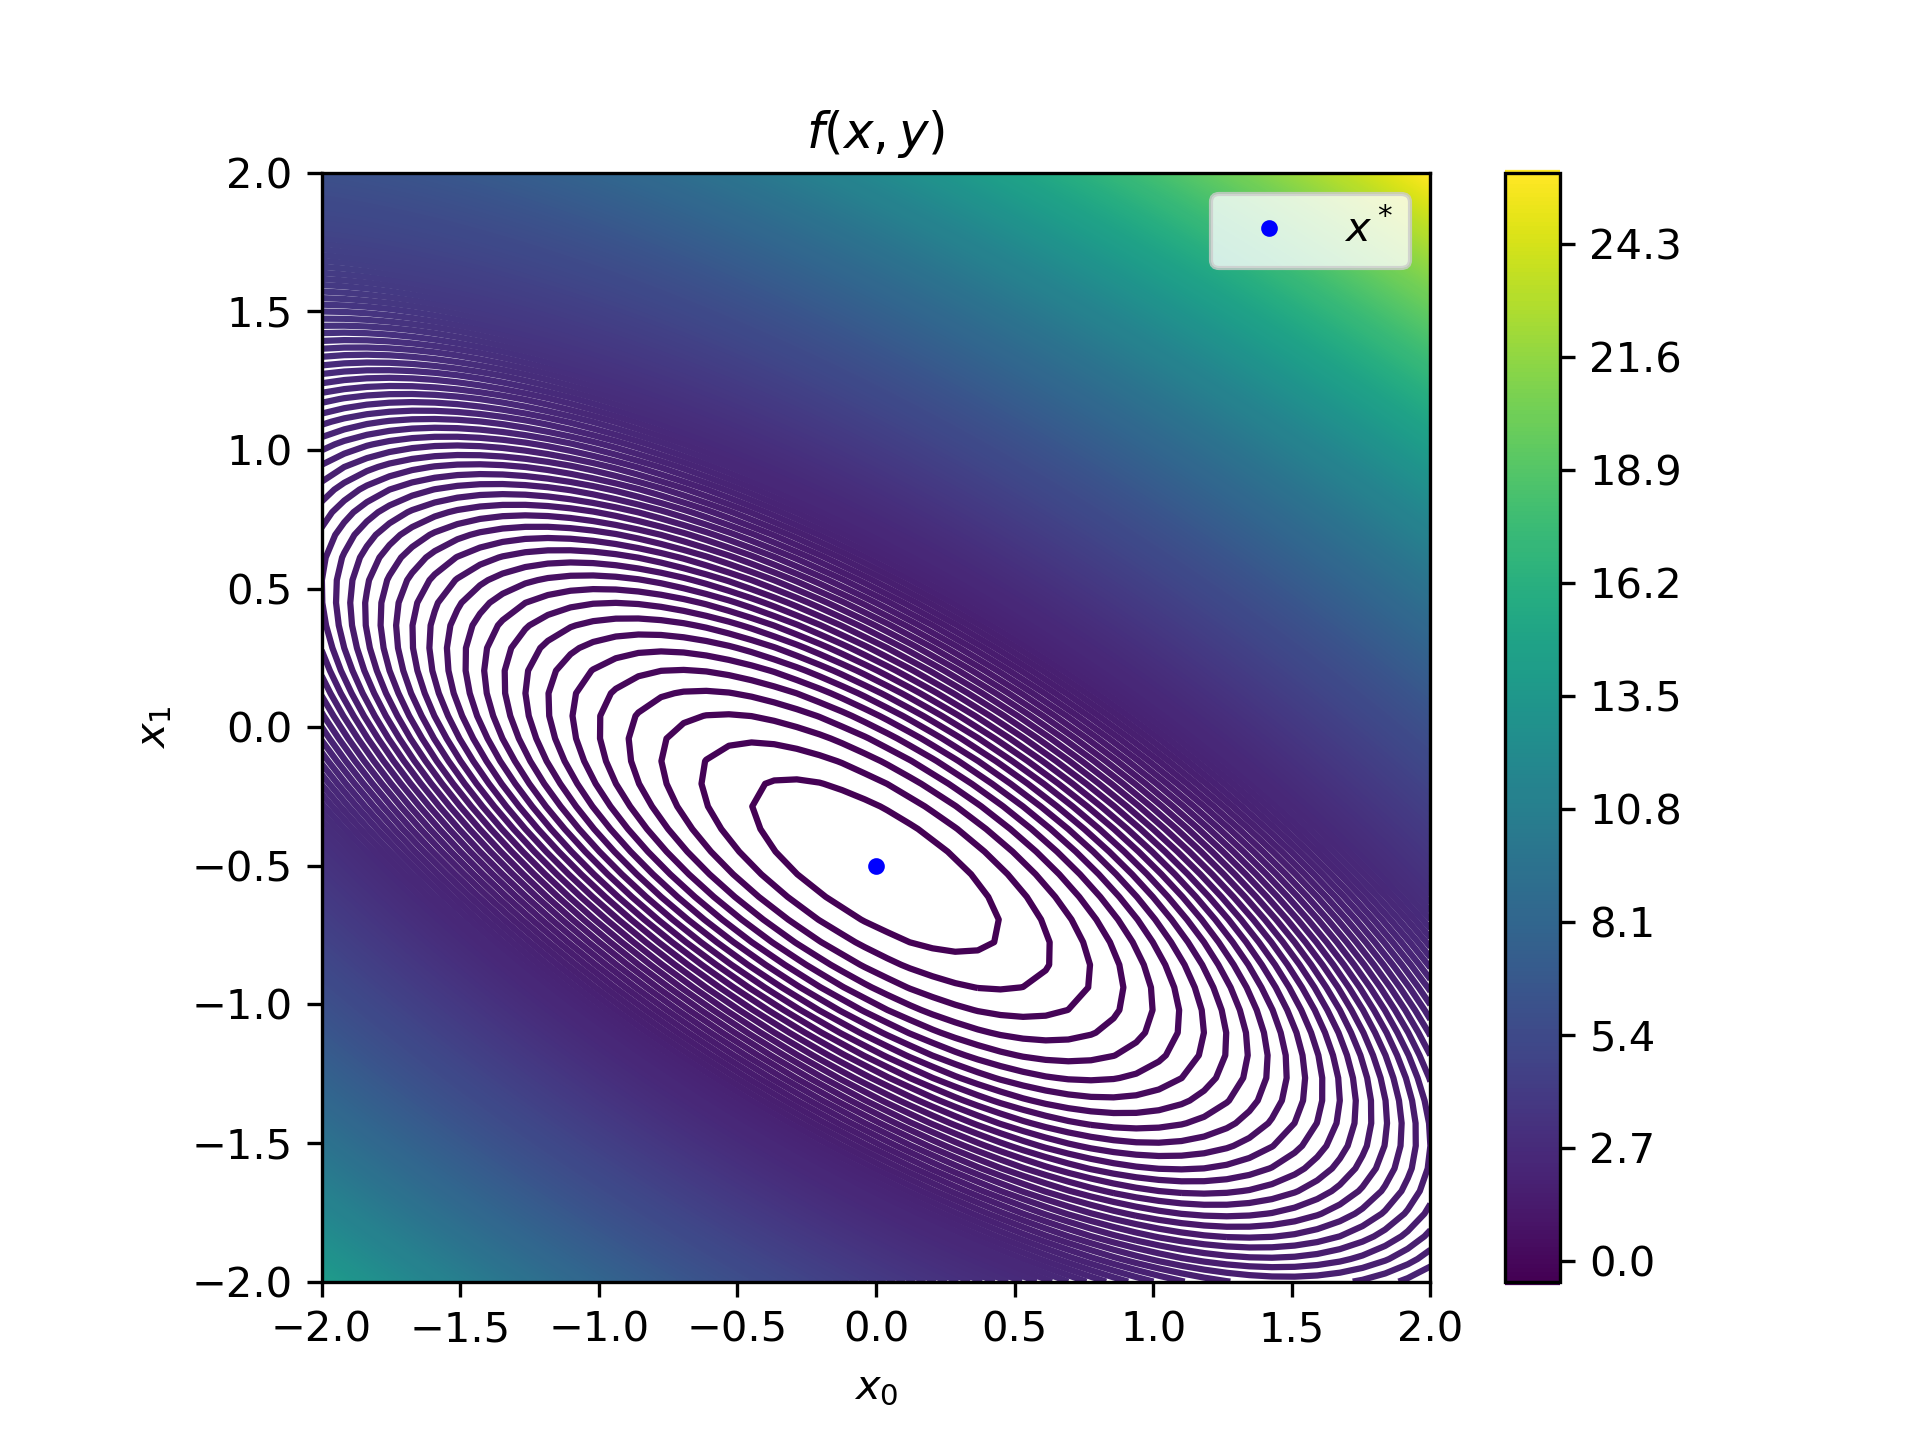

In [4]:
plt.figure(dpi=150)
xmin=-2
xmax=2
ymin=-2
ymax=2
aX0=np.linspace(xmin,xmax)
aX1=np.linspace(ymin,ymax)
Z=np.array([[F(np.array([x0,x1])) for x0 in aX0] for x1 in aX1])
plt.contour(aX0,aX1,Z,300)
plt.plot(x_star[0],x_star[1],'b.',label="$x^*$")
plt.axis('scaled')
plt.colorbar()
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.title('$f(x,y)$')
plt.legend()
plt.show()

Now let's write down our gradient descent algorithm.

In [5]:
def GDFixedStepSize(f, df, x0, step, eps, t_max):
    xtab = [x0]
    ftab = [f(x0)]
    t = 0
    while t == 0 or ((t < t_max) and (np.abs(f(xtab[-1]) - f(x_star)) > eps)):
        x = xtab[-1]
        x = x - step*df(x)
        xtab.append(x)
        ftab.append(f(x))
        t += 1
    xtab.append(x)
    ftab.append(f(x))
    return xtab, ftab

Now if we choose a starting point, say

$$
x_0 = \begin{pmatrix} 1.5 \\ 1 \end{pmatrix}.
$$

In [6]:
x0 = np.array([1.5, 1])

Then we can observe the values of $(x_k)_{k\in\mathbb{N}}$:

<IPython.core.display.Javascript object>


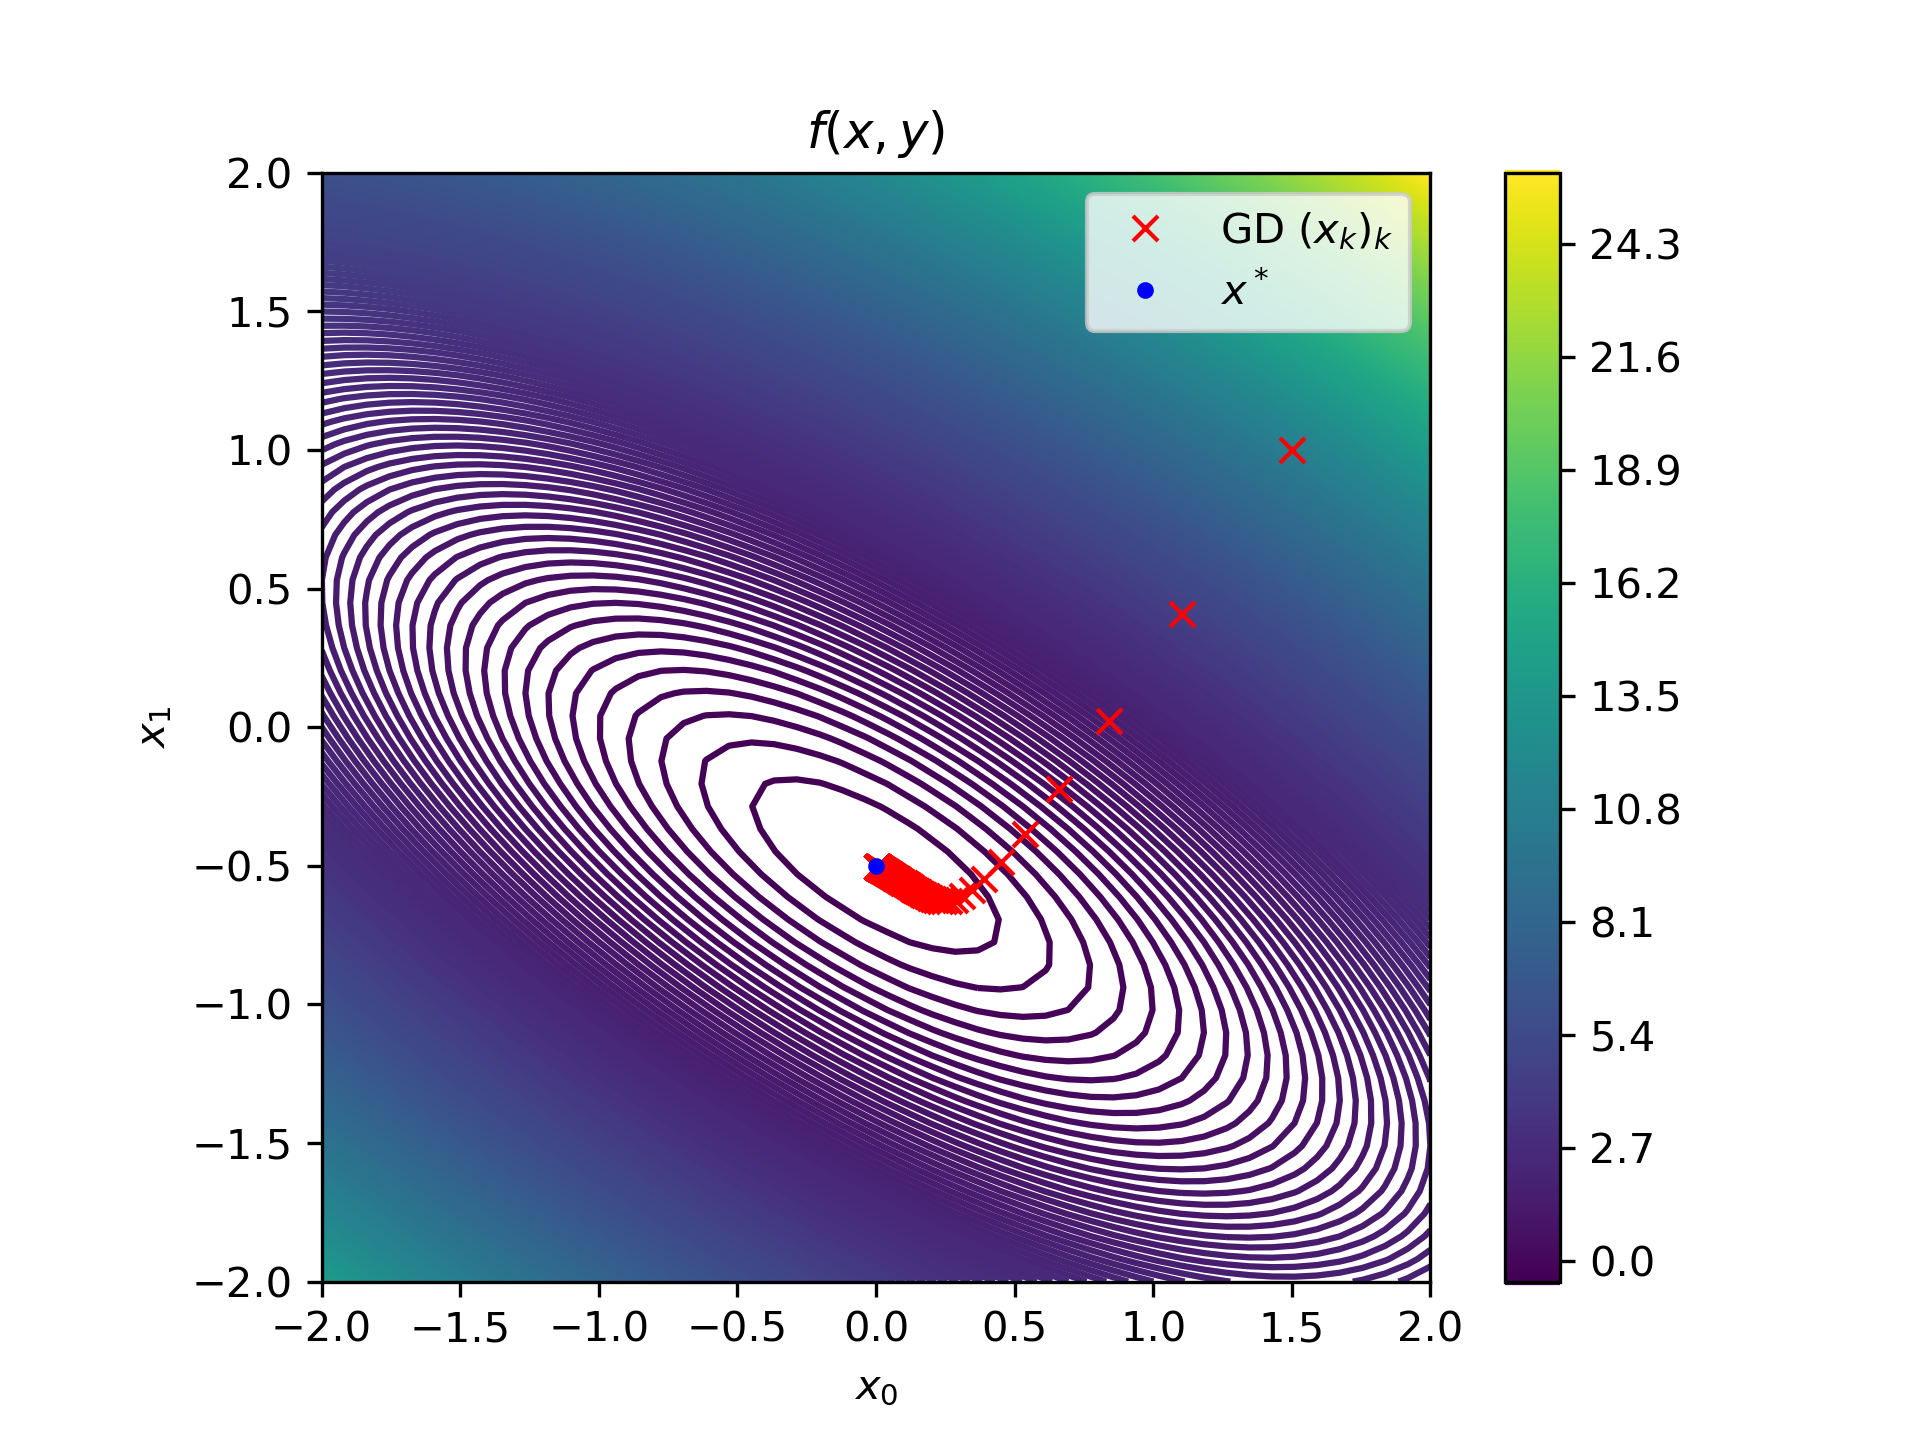

Algorithm converged?: True
Theoretical minimizer: [ 0.  -0.5] with a value of -0.5
Minimizer return by GD: [ 0.00422655 -0.50261215] with a value of -0.4999905704
Final number of iterations 91
Final error -9.4e-06


In [7]:
# Figure
plt.figure(dpi=150)
xmin=-2
xmax=2
ymin=-2
ymax=2

# Flotting function
aX0=np.linspace(xmin,xmax)
aX1=np.linspace(ymin,ymax)
Z=np.array([[F(np.array([x0,x1])) for x0 in aX0] for x1 in aX1])
plt.contour(aX0,aX1,Z,300)

# Gradient descent
step = 1/L
eps = 1e-5
t_max = 1e5
x_values, f_values = GDFixedStepSize(F, GradF, x0, step, eps, t_max)
plt.plot(x_values[0][0],x_values[0][1],'rx',label="GD $(x_k)_k$")
for x in x_values[1:]:
    plt.plot(x[0],x[1],'rx')

x_final = x_values[-1]
f_final = f_values[-1]
t_final = len(x_values)
print("Algorithm converged?:", t_final < t_max)
if len(x_values) < t_max:
    print("Theoretical minimizer:", x_star, "with a value of", "{:.10}".format(F(x_star)))
    print("Minimizer return by GD:", x_final, "with a value of", "{:.10}".format(f_final))
    print("Final number of iterations", t_final)
    print("Final error", "{:.2}".format(F(x_star)-f_final))
    
# Plotting minimizer
plt.plot(x_star[0],x_star[1],'b.',label="$x^*$")

plt.axis('scaled')
plt.colorbar()
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.title('$f(x,y)$')
plt.legend()
plt.show()

We can see that the algorithm converges to the theoretical minimizer and that the final error defined by

$$
g_n^* = \min_{0 \leq k \leq n} \lVert \nabla f (x_k) \rVert,
$$

verifies

$$
g_n^* \leq \frac{\sqrt{2L[f(x_0)-f(x^*)]}}{\sqrt{n+1}},
$$

as given by the theoretical guarantee [Sébastien Gadat, Optimisation for Big Data, Lecture Notes, 1.3.3.3].

In [8]:
g_n_star = min([np.linalg.norm(GradF(x_k)) for x_k in list(x_values)])
n = t_final
assert(g_n_star <= ((2*L*np.abs(F(x0) - F(x_star)))**0.5)/((n+1)**0.5))

#### 3 - Stochastic Mirror Descent

#### a - Intuition

As discussed above, solving the optimization problem on the whole space then projecting it on the simplex might be tricky. In order to avoid the projection step, SMD comes with the idea of changing the geometry of our space so that any point on the border of the constraint is at infinite distance from the points inside it. Then if we start our algorithm inside the constraint set, we would converge to the optimum inside it.



#### b - Deterministic case

For Gradient Descent, the iterative step expression was:

$$
\begin{align}
x_{t+1} &= x_t - \eta \nabla f (x_t) \\
&= argmin_{x \in \mathbb{R}^n} \Big\{ f(x_t) +  \langle \nabla f (x_t), x-x_t \rangle + \frac{1}{2 \eta} \lVert x-x_t \rVert_2^2 \Big\},
\end{align}
$$

where:

<ul>
    <li>
        $f(x_t) +  \langle \nabla f (x_t), x-x_t \rangle$: corresponds to a linear approximation of $f$ around $x_t$,
    </li>
    <li>
        $\frac{1}{2 \eta} \lVert x-x_t \rVert_2^2$: is the proximity term, corresponding to penalization with the Euclidean norm.
    </li>
</ul>

For Mirror Descent, we replace the Euclidean Norm seen in the proxmity term above by the <b>Bregman Divergence</b>, defined by:

$$
\forall u, v \in \Delta_m, \quad \mathcal{D}_{\phi}(u, v) = \phi(u) - \phi(v) - \langle \nabla \phi(v), u-v \rangle
$$

where $\phi$ correspond to the <b>entropy function</b> over the simplex $\Delta_m$ of probability distributions:

$$
\forall u \in \Delta_m, \quad \phi(u) = \sum_{i=1}^{m} u_i \log{u_i}.
$$

Hence, for a constant step-size, the iterative step expression can be written as:

$$
\begin{align}
x_{t+1} &= argmin_{x \in \mathbb{R}^n} \Big\{ f(x_t) +  \langle \nabla f (x_t), x-x_t \rangle + \frac{1}{\eta} \mathcal{D}_\phi (x,x_t) \Big\} \\
&= argmin_{x \in \mathbb{R}^n} \Big\{ \langle \nabla f (x_t), x-x_t \rangle + \frac{1}{\eta} \mathcal{D}_\phi (x,x_t) \Big\}
\end{align}
$$

The expression of the minimizer above can be made <b>explicit</b> as follows:

$$
\begin{align}
x_{t+1} &= argmin_{x \in \mathbb{R}^n} \Big\{ \langle \nabla f (x_t), x-x_t \rangle + \frac{1}{\eta} \mathcal{D}_\phi (x,x_t) \Big\} \\
&= argmin_{x \in \mathbb{R}^n} \Big\{ \langle \nabla f (x_t), x \rangle - \langle \nabla f (x_t), x_t \rangle + \frac{1}{\eta} \mathcal{D}_\phi (x,x_t) \Big\} \\
&= argmin_{x \in \mathbb{R}^n} \Big\{ \langle \nabla f (x_t), x \rangle + \frac{1}{\eta} \big( \phi(x) - \phi(x_t) - \langle \nabla \phi(x_t), x-x_t \rangle \big) \Big\} \\
&= argmin_{x \in \mathbb{R}^n} \Big\{ \langle \nabla f (x_t), x \rangle + \frac{1}{\eta} \big( \phi(x)  - \langle \nabla \phi(x_t), x \rangle - \langle \nabla \phi(x_t), x_t \rangle \big) \Big\} \\
&= argmin_{x \in \mathbb{R}^n} \Big\{ \langle \nabla f (x_t), x \rangle + \frac{1}{\eta} \big( \phi(x)  - \langle \nabla \phi(x_t), x \rangle \big) \Big\} \\
&= argmin_{x \in \mathbb{R}^n} \Big\{ \frac{1}{\eta} \phi(x) + \langle \nabla f (x_t) - \frac{1}{\eta} \nabla \phi(x_t), x \rangle \Big\}.
\end{align}
$$

Now define:

$$
h_{x_t}(x) := \frac{1}{\eta} \phi(x) + \langle \nabla f (x_t) - \frac{1}{\eta} \nabla \phi(x_t), x \rangle
$$

then:

$$
x_{t+1} = argmin_{x \in \Delta_m} h_{x_t}(x)
$$

To find the explicit expression of the minimizer, we proceed by solving $\frac{d}{dx} h_{x_t}(x) = 0$. We have:

$$
\begin{align}
& \quad \frac{d}{dx} h_{x_t}(x) = 0 \\
\iff & \quad \nabla f (x_t) - \frac{1}{\eta} \nabla \phi(x_t) + \frac{1}{\eta} \nabla \phi(x) = 0 \\
\iff & \quad \nabla \phi(x) = \nabla \phi(x_t) - \eta \nabla f (x_t) \\
\iff & \quad x = \big( \nabla \phi \big)^{-1} \big( \nabla \phi(x_t) - \eta \nabla f (x_t) \big) \\
\end{align}
$$

Now let

$$
y_{t+1} := argmin_{x \in \mathbb{R}^m} h_{x_t}(x)
$$

Then

$$
\begin{align}y_{t+1} &= \big( \nabla \phi \big)^{-1} \big( \nabla \phi(x_t) - \eta \nabla f (x_t) \big) \\
&= \big( \nabla \phi \big)^{-1} \big( \big[ 1 + \log{x_{t,i}} - \eta \big( \nabla f (x_t) \big)_i \big]_{i=1}^{m} \big) \\
&= \Big[  e^{\log{x_{t,i}} - \eta \big( \nabla f (x_t) \big)_i} \Big]_{i=1}^{m} \\
&= x_t e^{- \eta \nabla f (x_t)} \\
\end{align}.
$$

Now since $x_{t+1} = argmin_{x \in \Delta_m} h_{x_t}(x)$, then $x_{t+1}$ is the projection of $y_{t+1}$ on the simplex $\Delta_m$, that is,

$$
\begin{align}
x_{t+1} &= argmin_{x \in \Delta_m} \mathcal{D}_\phi(x, y_{t+1}).
\end{align}
$$

We introduce the Lagrange multiplier:

$$
\begin{align}
\mathcal{L}(x,\lambda) &= h_{x_t}(x) + \lambda \Big( \sum_{i=1}^{m} x_i - 1 \Big) \\
&= \frac{1}{\eta} \phi(x) + \langle \nabla f (x_t) - \frac{1}{\eta} \nabla \phi(x_t), x \rangle + \lambda \Big( \sum_{i=1}^{m} x_i - 1 \Big) \\
&= \frac{1}{\eta} \sum_{i=1}^{m} x_i \log{x_i} + \langle \nabla f (x_t) - \frac{1}{\eta} \nabla \phi(x_t), x \rangle + \lambda \Big( \sum_{i=1}^{m} x_i - 1 \Big)
\end{align}
$$

Hence, the stationary point $(x_{t+1}, \lambda^*)$ of $\mathcal{L}$ is such that:

$$
\begin{cases}
\frac{\partial \mathcal{L(x,\lambda)}}{\partial x_i} \big|_{(x_{t+1}, \lambda^*)} = 0 \\
\frac{\partial \mathcal{L(x,\lambda)}}{\partial \lambda} \big|_{(x_{t+1}, \lambda^*)} = 0
\end{cases}
$$

Therefore

$$
\begin{cases}
\frac{1}{\eta} \big(1+ \log{(x_{t+1})_i}\big) + \Big(  \nabla f (x_t) - \frac{1}{\eta} \nabla \phi(x_t) \Big)_i + \lambda^* = 0 \\
\sum_{i=1}^{m} (x_{t+1})_i - 1 = 0
\end{cases}
$$

Hence

$$
\begin{cases}
\log{(x_{t+1})_i} = \nabla \phi(x_t)_i - \eta \nabla f (x_t)_i - 1 - \eta \lambda^*\\
\sum_{i=1}^{m} (x_{t+1})_i = 1
\end{cases}
$$

Thus

$$
\begin{cases}
(x_{t+1})_i = e^{\nabla \phi(x_t)_i - 1} e^{- \eta \nabla f (x_t)_i - \eta \lambda^*} = (x_t)_i e^{- \eta \nabla f (x_t)_i - \eta \lambda^*} \\
\sum_{i=1}^{m} (x_{t+1})_i = 1
\end{cases}
$$

Now substituting the expression of $(x_{t+1})_i$ into $\sum_{i=1}^{m} (x_{t+1})_i$, we get

$$
\begin{align}
\sum_{i=1}^{m} (x_{t+1})_i &= \sum_{i=1}^{m} (x_t)_i e^{- \eta \nabla f (x_t)_i - \eta \lambda^*} \\
&= e^{- \eta \lambda^*} \sum_{i=1}^{m} (x_t)_i e^{- \eta \nabla f (x_t)_i}
\end{align}
$$

Substituting this in the second equation in the system above, we get:

$$
e^{\eta \lambda^*} = \sum_{i=1}^{m} (x_t)_i e^{- \eta \nabla f (x_t)_i}
$$

Hence

$$
\forall i \in \{1,\dots,m\}, \quad (x_{t+1})_i = \frac{(x_t)_i e^{- \eta \nabla f (x_t)_i}}{\sum_{i=1}^{m} (x_t)_i e^{- \eta \nabla f (x_t)_i}}
$$

Which gives

$$
x_{t+1} = \frac{x_t e^{- \eta \nabla f (x_t)}}{\lVert x_t e^{- \eta \nabla f (x_t)} \rVert_1}.
$$

In [9]:
A = np.array([[1, 1, 1],
              [1, 2, 3],
              [2, 1, 4]])

b = np.array([2, 1/2, 1/2])

def F(x):
    return np.dot(x,np.dot(A,x)) + np.dot(b,x)

def GradF(x):
    return 2*np.dot(A,x) + b

# L = 8 + 2*(13**0.5)
L = 10

In [10]:
# x_star = -(1/2)*np.linalg.inv(A)@b

In [11]:
# x_star

In [12]:
# Projection tools

T = np.array([[1/2, 0, -1/2],
              [0, np.sqrt(3)/2, 0]])

TinvA = np.array([[1, -1/np.sqrt(3)],
                  [0, 2/np.sqrt(3)]])
Tinvb = np.array([1/2, 0])

def project_and_get_image(x):
    x, y = TinvA@x+Tinvb
    return F(np.array([x, y, 1-x-y]))

def project_on_simplex(x):
    return T@x

<IPython.core.display.Javascript object>


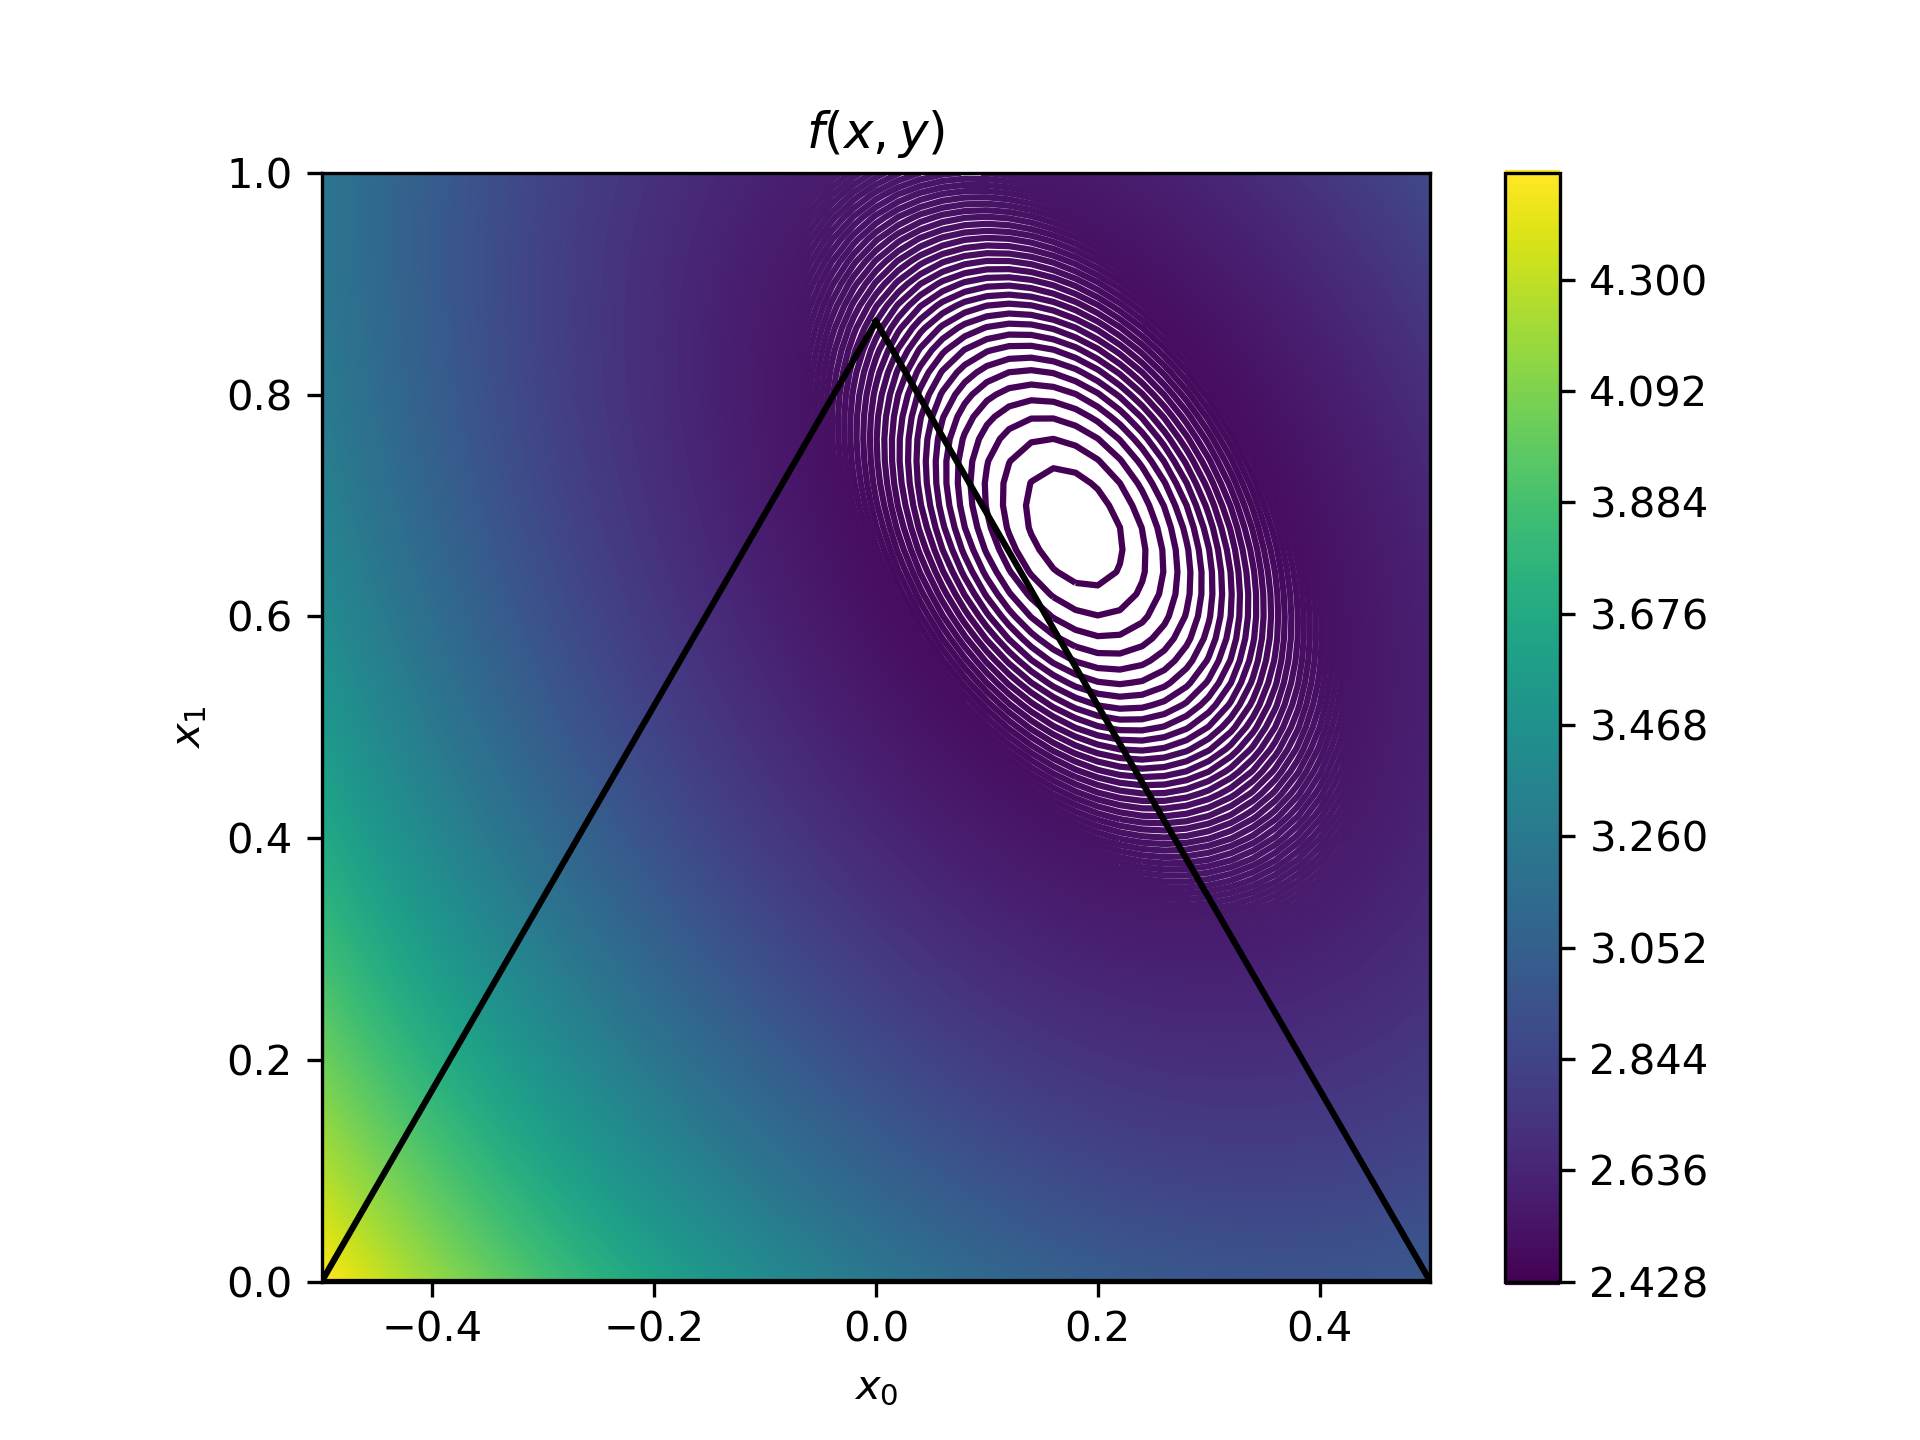

In [13]:
# Plot F

plt.figure(dpi=150)
xmin = -1/2
xmax = 1/2
ymin = 0
ymax = 1
aX0 = np.linspace(xmin,xmax, 51)
aX1 = np.linspace(ymin,ymax, 51)
Z=np.array([[project_and_get_image(np.array([x0, x1])) for x0 in aX0] for x1 in aX1])
plt.contour(aX0,aX1,Z,600)
#plt.plot(x_star[0],x_star[1],'b.',label="$x^*$")
aX0pos = np.array([x for x in aX0 if x >= 0])
aX0neg = np.array([x for x in aX0 if x <= 0])
plt.plot(aX0pos, -np.sqrt(3)*aX0pos+(np.sqrt(3)/2), 'k-')
plt.plot(aX0neg, np.sqrt(3)*aX0neg+(np.sqrt(3)/2), 'k-')
plt.plot(aX0, np.zeros(len(aX0)), 'k-')
plt.axis('scaled')
plt.colorbar()
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.title('$f(x,y)$')
# plt.legend()
plt.show()

In [14]:
def MDFixedStepSize(f, df, x0, step, eps, t_max):
    xtab = [x0]
    ftab = [f(x0)]
    t = 0
    while t <= 1 or ((t < t_max) and (np.abs(f(xtab[-1]) - f(xtab[-2])) > eps)):
    # while t <= 1 or ((t < t_max) and (np.abs(df(xtab[-1])).any() > eps)):
        x = xtab[-1]
        tmp = x*np.exp(-step*df(x))
        x = tmp/sum(tmp)
        xtab.append(x)
        ftab.append(f(x))
        t += 1
    xtab.append(x)
    ftab.append(f(x))
    return xtab, ftab

In [15]:
x0 = np.array([1/3, 1/3, 1/3])

<IPython.core.display.Javascript object>


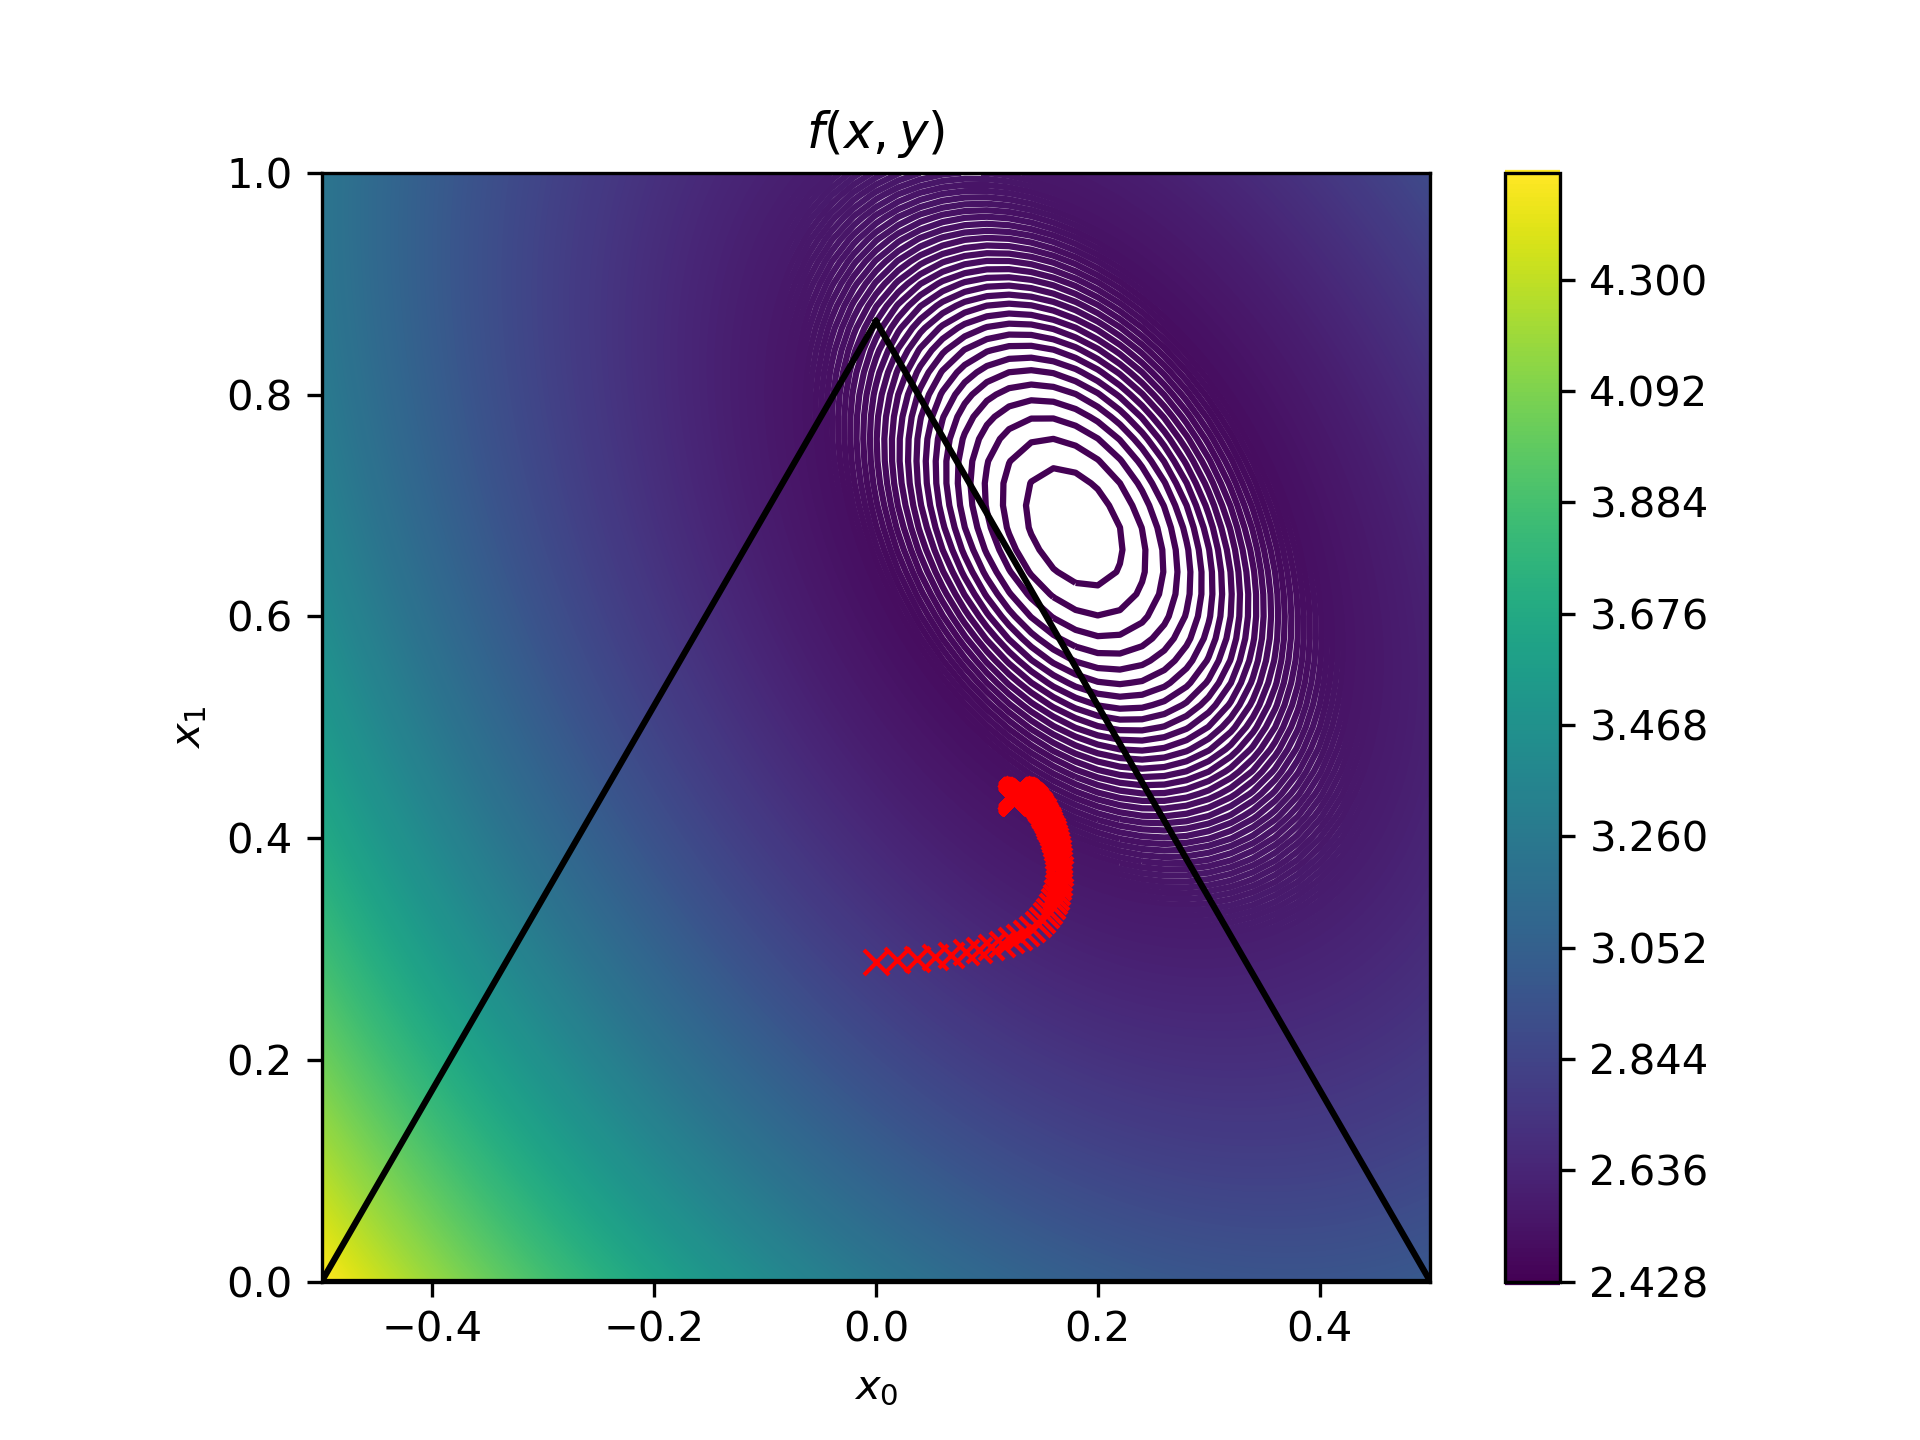

Algorithm converged?: True
Minimizer return by MD: [0.37499729 0.49999689 0.12500582] with a value of 2.531254075
Final number of iterations 255
Final F 2.531254075
Min F 2.520348457


In [16]:
# Figure
plt.figure(dpi=150)
xmin = -1/2
xmax = 1/2
ymin = 0
ymax = 1

# Plotting function
aX0 = np.linspace(xmin,xmax, 51)
aX1 = np.linspace(ymin,ymax, 51)
Z=np.array([[project_and_get_image(np.array([x0, x1])) for x0 in aX0] for x1 in aX1])
plt.contour(aX0,aX1,Z,600)

# Plotting Simplex
aX0pos = np.array([x for x in aX0 if x >= 0])
aX0neg = np.array([x for x in aX0 if x <= 0])
plt.plot(aX0pos, -np.sqrt(3)*aX0pos+(np.sqrt(3)/2), 'k-')
plt.plot(aX0neg, np.sqrt(3)*aX0neg+(np.sqrt(3)/2), 'k-')
plt.plot(aX0, np.zeros(len(aX0)), 'k-')

# Mirror descent
step = 1/L
eps = 1e-8
t_max = 1e5
x_values, f_values = MDFixedStepSize(F, GradF, x0, step, eps, t_max)
# plt.plot(x_values[0][0],x_values[0][1],'rx',label="GD $(x_k)_k$")
for x in x_values:
    assert(np.abs(sum(x) - 1) < 1e-3)
    x = project_on_simplex(x)
    plt.plot(x[0],x[1],'rx')

x_final = x_values[-1]
f_final = f_values[-1]
t_final = len(x_values)
print("Algorithm converged?:", t_final < t_max)
if len(x_values) < t_max:
    print("Minimizer return by MD:", x_final, "with a value of", "{:.10}".format(f_final))
    print("Final number of iterations", t_final)
    print("Final F", "{:.10}".format(f_final))
    print("Min F", "{:.10}".format(min(f_values)))
    
# Plotting minimizer
# plt.plot(x_star[0],x_star[1],'b.',label="$x^*$")

plt.axis('scaled')
plt.colorbar()
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.title('$f(x,y)$')
# plt.legend()
plt.show()

### III - Portfolio hedging under CV@R$_\alpha$ constraint

### 1 - Portfolio structure

We consider a portfolio of $m$ financial assets $S = (S^1,\dots,S^m)$. We assume that the portfolio is formed exclusively of risky assets encoded by geometric Brownian motions, that is:

$$
\forall i \in \{1,\dots,m\}, \quad dS^i_t = \mu_i S^i_t dt + \sigma_i S^i_t dW_t,
$$

which has the solution:

$$
S^i_{t} = S^i_0 e^{\big( \mu_i - \frac{\sigma_i^2}{2}\big) t + \sigma_i W_t},
$$

or equivalently:

$$
\log{\frac{S^i_{t}}{S^i_0}} = \Big( \mu_i - \frac{\sigma_i^2}{2}\Big) t + \sigma_i W_t,
$$

where $W_t$ is a Browninan motion, $\mu_i$ and $\sigma_i$ are constants. 


We have:

$$
\log{\frac{S^i_{t+1}}{S^i_{t}}} = \Big( \mu_i - \frac{\sigma_i^2}{2}\Big) + \sigma_i \big( W_{t+1} - W_t \big) \sim \mathcal{N} \Big( \mu_i - \frac{\sigma_i^2}{2}, \sigma_i^2 \Big),
$$

hence, we get:

$$
\begin{cases}
\mathbb{E} \Big[ \log{\frac{S^i_{t+1}}{S^i_{t}}} \Big] = \mu_i - \frac{\sigma_i^2}{2} \\
\Var{\Big[ \log{\frac{S^i_{t+1}}{S^i_{t}}} \Big]} = \sigma_i^2.
\end{cases}
$$

Using the Law of Large Numbers, these two can be approximated given an $n-$sample $(X_1,\dots, X_n)$ of random vectors such that

$$
\forall t \in \{1,\dots,n\}, \quad X^i_t \sim \log{\frac{S^i_{t+1}}{S^i_{t}}},
$$

with the empirical mean and the empirical variance using the formulae:

$$
\begin{cases}
\bar{X}_n = \frac{1}{n} \sum_{t = 1}^{n} X_t  \longrightarrow_{n \rightarrow +\infty} \mathbb{E}  \Big[ \log{\frac{S_{t+1}}{S_{t}}} \Big] \\
\frac{1}{n-1} \sum_{t = 1}^{n} \big(X_t - \bar{X}_n\big)^2  \longrightarrow_{n \rightarrow +\infty} \Var{\Big[ \log{\frac{S_{t+1}}{S_{t}}} \Big]}.
\end{cases}
$$

Therefore, we will approximate given an $n-$sample $(X_1,\dots, X_n)$ where $X_t \sim \log{\frac{S_{t+1}}{S_{t}}}$ the parameters $\mu$ and $\sigma$ using the estimators $\hat{\mu}_n$ and $\hat{\sigma}_n$ such that:

$$
\begin{cases}
\bar{X}_n = \hat{\mu}_n - \frac{1}{2} \hat{\sigma}_n^2 \\
\frac{1}{n-1} \sum_{j = 1}^{n} \big(X_j - \bar{X}_n\big)^2 = \hat{\sigma}_n^2.
\end{cases}
$$

We obtain the following iterative expressions for the sequence of estimators $(\hat{\mu}_n, \hat{\sigma}_n^2)_{n\geq0}$ (proof in Appendix B):

$$
\begin{cases}
\hat{\mu}_{n+1} = \frac{n}{n+1} \hat{\mu}_n - \frac{1}{2n(n+1)} \hat{\sigma}_n^2 + \frac{1}{n+1} X_{n+1} + \frac{1}{2(n+1)} \big( \hat{\mu}_n - \frac{1}{2} \hat{\sigma}_n^2 - X_{n+1} \big)^2 \\
\hat{\sigma}_{n+1}^2 =  \frac{n-1}{n} \hat{\sigma}_n^2 + \frac{1}{n+1} \big( \hat{\mu}_n - \frac{1}{2} \hat{\sigma}_n^2 - X_{n+1} \big)^2.
\end{cases}
$$

#### Testing

In [17]:
def sample_next(S_n, mu, sigma2):
    m = len(S_n)
    N = np.random.normal(0, 1, m)
    res = S_n * np.exp(mu - sigma2/2 + np.sqrt(sigma2)*N)
    return np.maximum(res, np.ones(shape=np.shape(res)))
    

def iterative_step(mu_n, sigma2_n, X_nplus1, n):
    """
    Given mu_n, sigma2_n and X_nplus1, returns mu_nplus1 and sigma2_nplus1.
    """
    mu_nplus1 = (n/(n+1))*mu_n - (1/(2*n*(n+1)))*sigma2_n + (1/(n+1))*X_nplus1 + (1/(2*(n+1)))*(mu_n - sigma2_n/2 - X_nplus1)**2
    sigma2_nplus1 = ((n-1)/n)*sigma2_n + (1/(n+1))*(mu_n - sigma2_n/2 - X_nplus1)**2
    return mu_nplus1, sigma2_nplus1

def estimate_mu_sigma2(mu = np.array([0.03, 0.02]), sigma2 = np.array([0.06, 0.03]), S_1 = np.array([1000, 2000]), eps = 1e-6, n_max = 1e5):
    mu_hat = 10*np.ones(shape=np.shape(S_1))
    sigma2_hat = 10*np.ones(shape=np.shape(S_1))
    mu_hat_tab = [mu_hat]
    sigma2_hat_tab = [sigma2_hat]
    n = 1
    S_n = S_1
    while n == 1 or (n < n_max and (np.abs(mu_hat_tab[-1]-mu_hat_tab[-2]).max() > eps or np.abs(sigma2_hat_tab[-1]-sigma2_hat_tab[-2]).max() > eps)):
        S_nplus1 = sample_next(S_n, mu, sigma2)
        X_nplus1 = np.log(S_nplus1/S_n)
        mu_hat, sigma2_hat = iterative_step(mu_hat, sigma2_hat, X_nplus1, n)
        mu_hat_tab.append(mu_hat)
        sigma2_hat_tab.append(sigma2_hat)
        n += 1
        S_n = S_nplus1
    if n == n_max:
        print("Didn't converge")
    print("mu", mu)
    print("mu_hat", mu_hat_tab[-1])
    print("sigma2", sigma2)
    print("sigma2_hat", sigma2_hat_tab[-1])
    print("number of iteratations", n)

In [18]:
estimate_mu_sigma2()

mu [0.03 0.02]
mu_hat [0.03009534 0.01963747]
sigma2 [0.06 0.03]
sigma2_hat [0.05956016 0.03062698]
number of iteratations 55017


In [19]:
estimate_mu_sigma2(mu = np.array([0., 0., 0]), sigma2 = np.array([0.06, 0.03, 0.2]), S_1 = np.array([1000, 2000, 100]), eps = 1e-5, n_max = 1e5)

mu [0. 0. 0.]
mu_hat [0.02555823 0.01422149 0.06900189]
sigma2 [0.06 0.03 0.2 ]
sigma2_hat [0.05095637 0.02884545 0.13782712]
number of iteratations 11770


### 2 - Online algorithm for portfolio optimization

In the algorithm below, we assume that we have an optimization algorithm $\omega^*$ seen in [Costa, Gadat, Huang] which given the parameter $\theta = \big( \mu, \sigma^2 \big)$ of the distribution of assets, returns the strategy $\omega^*(\theta)$ maximizing the expected return using the Stochastic Mirror Descent algorithm seen above.

<ol>
    <li>
        At time $t = 0$ do:
        <ul>
            <li>observe the values of the portfolio assets $S_0 = \big(S^1_0, \dots, S^m_0 \big)$,</li>
            <li>initialize $\hat{\theta}_0 = \big(\hat{\mu}_0, \hat{\sigma}_0^2\big)$ randomly,
            </li>
            <li>using SMD, set the strategy to $\omega^*\big(\hat{\theta}_0\big)$.</li>
        </ul>
    </li>
    <br>
    <li>
        For $n \geq 0$, at time $t = n+1$ do:
        <ul>
            <li>observe the values of the portfolio assets $S_{n+1} = \big(S^1_{n+1}, \dots, S^m_{n+1} \big)$,</li>
            <li>compute $X_{n+1} = \big(X^1_{n+1}, \dots, X^m_{n+1} \big)$:
$$
\forall i \in \{1,\dots,m\}, \quad
X_{n+1}^i = \log{\frac{S^i_{n+1}}{S^i_n}},
$$
            </li>
            <li>compute the value of  $\hat{\theta}_{n+1} = \big(\hat{\mu}_{n+1}, \hat{\sigma}_{n+1}^2\big)$ iteratively:           
$$
\begin{cases}
\hat{\mu}_{n+1} = \frac{n}{n+1} \hat{\mu}_n - \frac{1}{2n(n+1)} \hat{\sigma}_n^2 + \frac{1}{n+1} X_{n+1} + \frac{1}{2(n+1)t} \big( \hat{\mu}_n - \frac{1}{2} \hat{\sigma}_n^2 - X_{n+1} \big)^2 \\
\hat{\sigma}_{n+1}^2 =  \frac{n-1}{n} \hat{\sigma}_n^2 + \frac{1}{(n+1)t} \big( \hat{\mu}_n - \frac{1}{2} \hat{\sigma}_n^2 - X_{n+1} \big)^2,
\end{cases}
$$               
            </li>
            <li>using SMD, set the strategy to $\omega^*\big(\hat{\theta}_{n+1}\big)$.</li>
        </ul>
    </li>
</ol>

### 3 - Optimizing return given estimated asset distributions

Here we discuss how we get $\omega^*(\theta_n)$ given the parameter $\theta_n = \big(\mu, \sigma^2 \big)$ of distribution of assets at time $n$.

We have

$$
\omega^*(\theta_n) = argmax_{\begin{cases}u \in \Delta_m \\ CV@R(u)\leq \alpha\end{cases}} \sum_{i=1}^{m} u_i \mathbb{E}\big[ Z_n^i \big],
$$

where

$$
Z_n^i = \frac{S_{n+1}^i}{S_{n}^i} - 1,
$$

which, assuming $S_{t}^i \sim \mathcal{GBM(\mu_{i}, \sigma^2_{i})}$, has the expression:

$$
\begin{align}
Z_n^i &= \frac{S_{n+1}^i}{S_{n}^i} - 1\\
&= \frac{S_{0}e^{\big( \mu_{i} - \frac{\sigma_{i}^2}{2}\big)(n+1) + \sigma_{i} W_{n+1}}}{S_{0}e^{\big( \mu_{i} - \frac{\sigma_{i}^2}{2}\big)n + \sigma_{i} W_n}} - 1 \\
&= e^{ \mu_{i} - \frac{\sigma_{i}^2}{2} + \sigma_{i} N} - 1, \quad N \sim \mathcal{N}(0,1).
\end{align}
$$

The problem above can also be expressed as the family of optimization problems $(Q_{\lambda})_{\lambda}$:

$$
Q_\lambda = argmin_{(u,\theta)\in\Delta_m\times\mathbb{R}} \{ p_\lambda(u,\theta) \},
$$

with

$$
p_\lambda(u,\theta) = - \sum_{i=1}^{m} u_i\mathbb{E}[Z_n^i] + \lambda \psi_\alpha(\theta,u),
\quad
\psi_\alpha(u,\theta) = \theta + \frac{1}{1-\alpha}\mathbb{E}\big[\lfloor \langle Z,u\rangle - \theta\rfloor_+\big],
$$

which can be written as an expectation:

$$
p_\lambda(u,\theta) = \mathbb{E}\Big[ - \langle Z,u\rangle + \lambda \theta + \frac{\lambda}{1-\alpha} \lfloor \langle Z,u\rangle - \theta\rfloor_+ \Big].
$$


We use SMD to solve the optimization problem above, for which the iterative step is explicit:

$$
X_{k+1} =
\begin{pmatrix} U^{k+1} \\ \theta^{k+1} \end{pmatrix}
\quad \text{with} \quad
\begin{cases}
U^{k+1} = \frac{U^k e^{-\eta_{k+1} \partial_{u} p_\lambda ( U^k, \theta^k )}}{\lVert U^k e^{-\eta_{k+1} \partial_{u} p_\lambda ( U^k, \theta^k )} \rVert_1} \\
\theta^{k+1} = \theta^{k} - \eta_{k+1} \partial_{\theta} p_\lambda \big( U^k, \theta^k \big).
\end{cases}
$$

The expression of the gradient of $p_\lambda$ in the equality above is given by:

$$
\begin{cases}
\partial_{u} p_\lambda ( u, \theta ) =  \mathbb{E} \Big[ \big( -1 + \frac{\lambda}{1-\alpha}  \mathbb{1}_{ \scriptsize \{ \langle Z,u\rangle \geq \theta \}} \big) Z \Big] \\
\partial_{\theta} p_\lambda ( u, \theta ) = \mathbb{E} \Big[ \lambda - \frac{\lambda}{1-\alpha} \mathbb{1}_{ \scriptsize \{ \langle Z,u\rangle \geq \theta \}} \Big],
\end{cases}
$$

Hence, the gradient can be estimated by:

$$
\begin{cases}
\partial_{u} p_\lambda ( u, \theta ) \approx \big( -1 + \frac{\lambda}{1-\alpha}  \mathbb{1}_{ \scriptsize \{ \langle Z_k,u\rangle \geq \theta \}} \big) Z_k \\
\partial_{\theta} p_\lambda ( u, \theta ) \approx \lambda - \frac{\lambda}{1-\alpha} \mathbb{1}_{ \scriptsize \{ \langle Z_k',u\rangle \geq \theta \}},
\end{cases}
\quad \text{where } 
\begin{cases}
Z_k = e^{ \mu_{i} - \frac{\sigma_{i}^2}{2} + \sigma_{i} N} - 1 \\
Z_k' = e^{ \mu_{i} - \frac{\sigma_{i}^2}{2} + \sigma_{i} N'} - 1
\end{cases}
, \quad N, N' \sim \mathcal{N}(0,1).
$$

### IV - Simulations

We start by simulating a GBM given its parameters $\mu$ and $\sigma^2$:

#### 1 - Simulation of a Geometric Brownian Motion

<b>a - Simulating a Brownian Motion</b>

In [20]:
dt = 1e-2

<IPython.core.display.Javascript object>


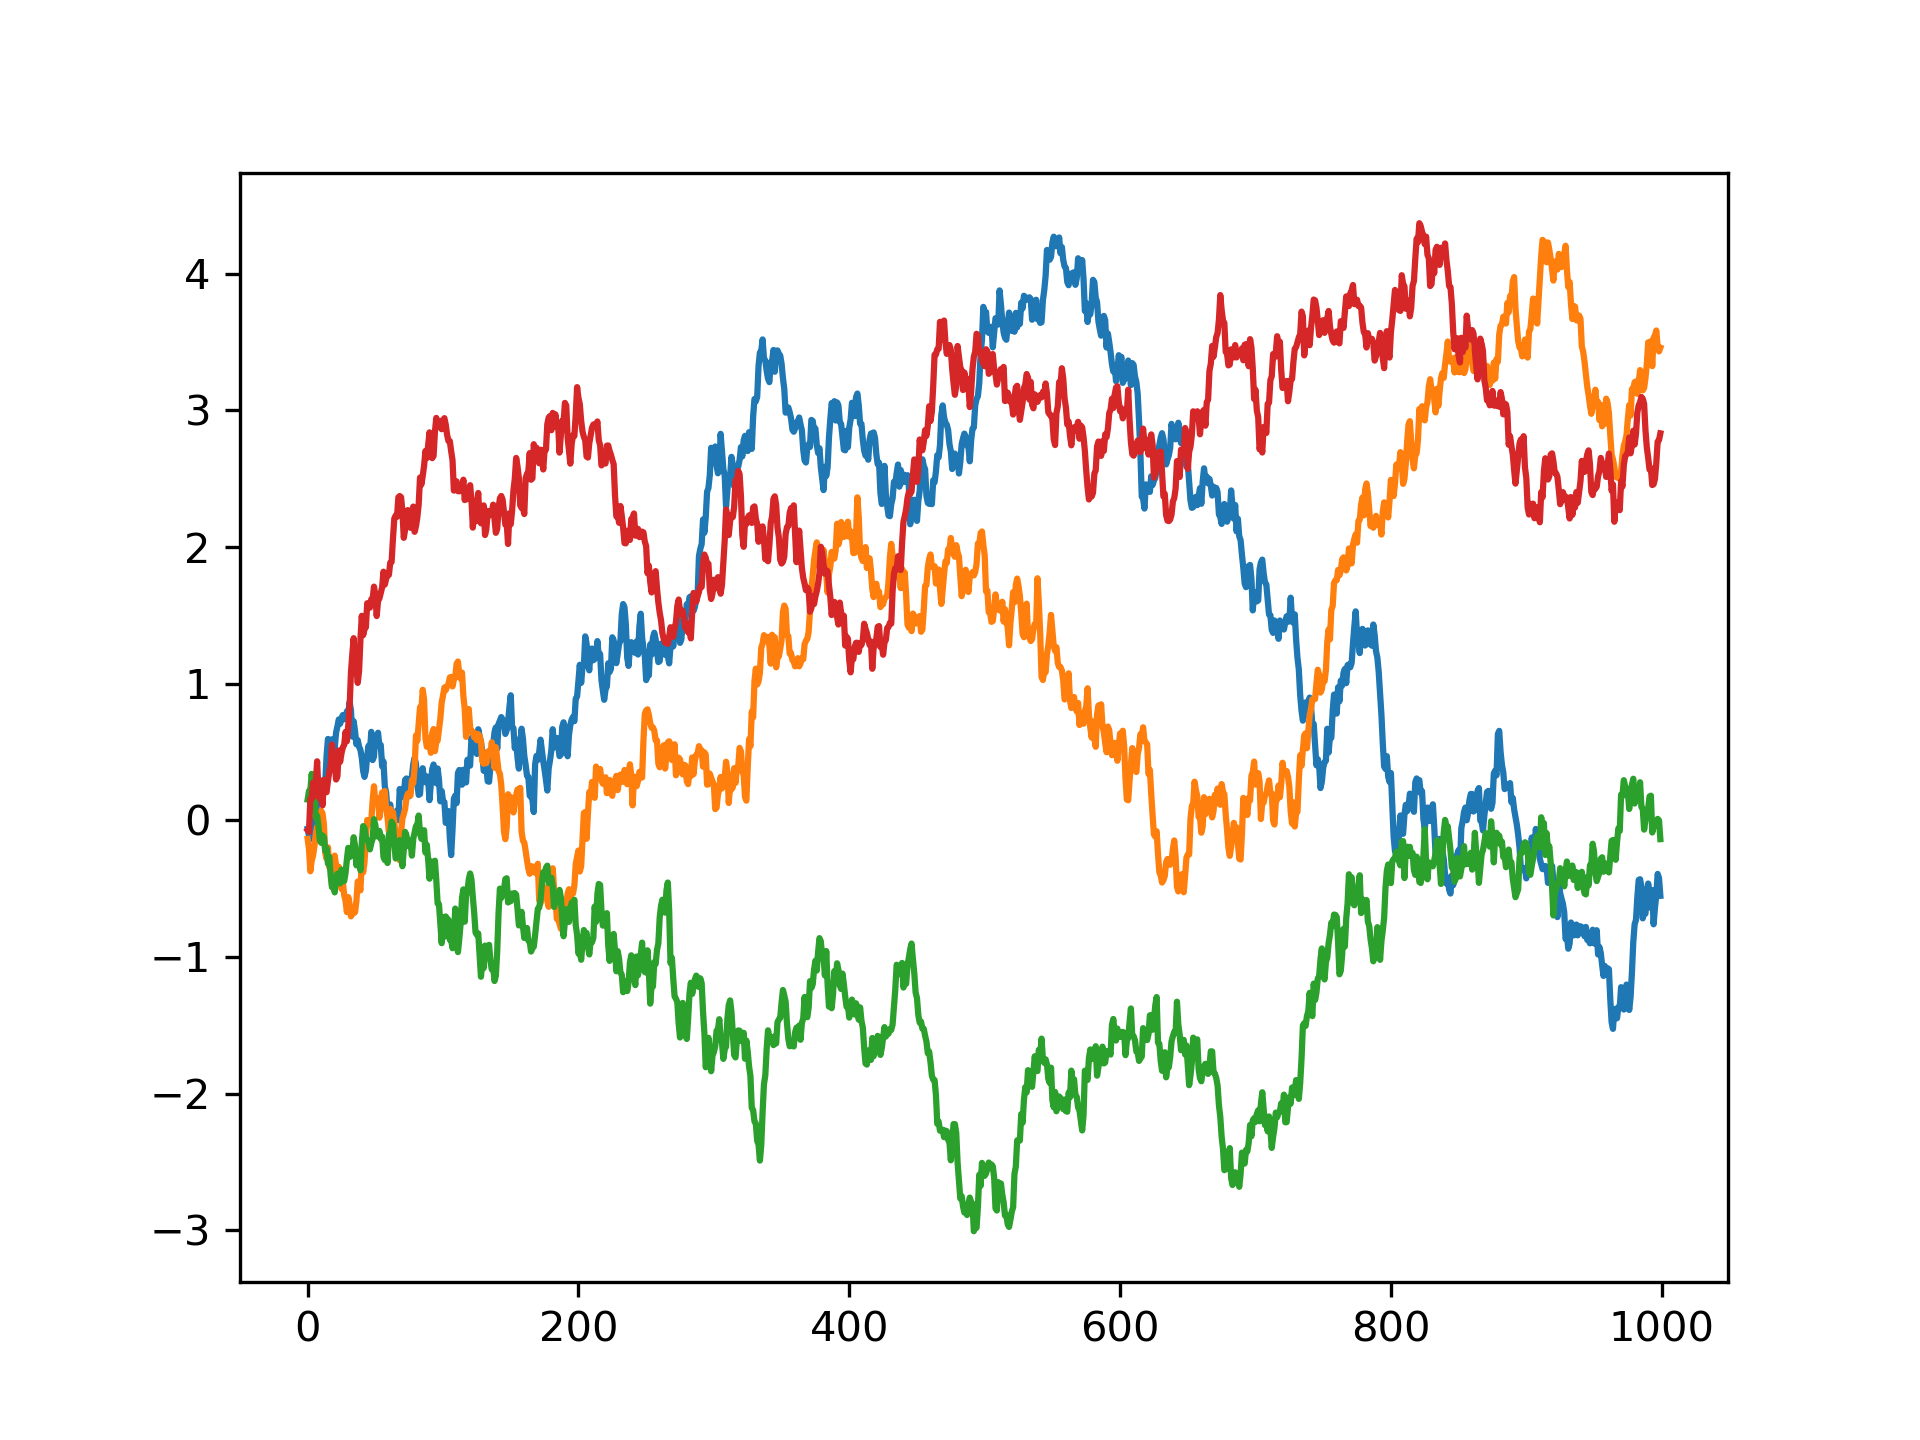

In [21]:
plt.figure(dpi=150)

def get_W(T):
    return np.cumsum(np.random.normal(0,np.sqrt(dt),T))

plt.plot(get_W(1000))
plt.plot(get_W(1000))
plt.plot(get_W(1000))
plt.plot(get_W(1000))
plt.show()

<b>b - Simulating a Geometric Brownian Motion</b>

In [22]:
def get_GBM(T, S0, mu, sigma2):
    return S0*np.cumprod(np.exp(dt*(mu - sigma2/2)*np.ones(T) + np.sqrt(sigma2)*np.random.normal(0, np.sqrt(dt), T)))

In [23]:
s = np.mean(get_GBM(1000000, 1000, 0, 0.06))

<IPython.core.display.Javascript object>


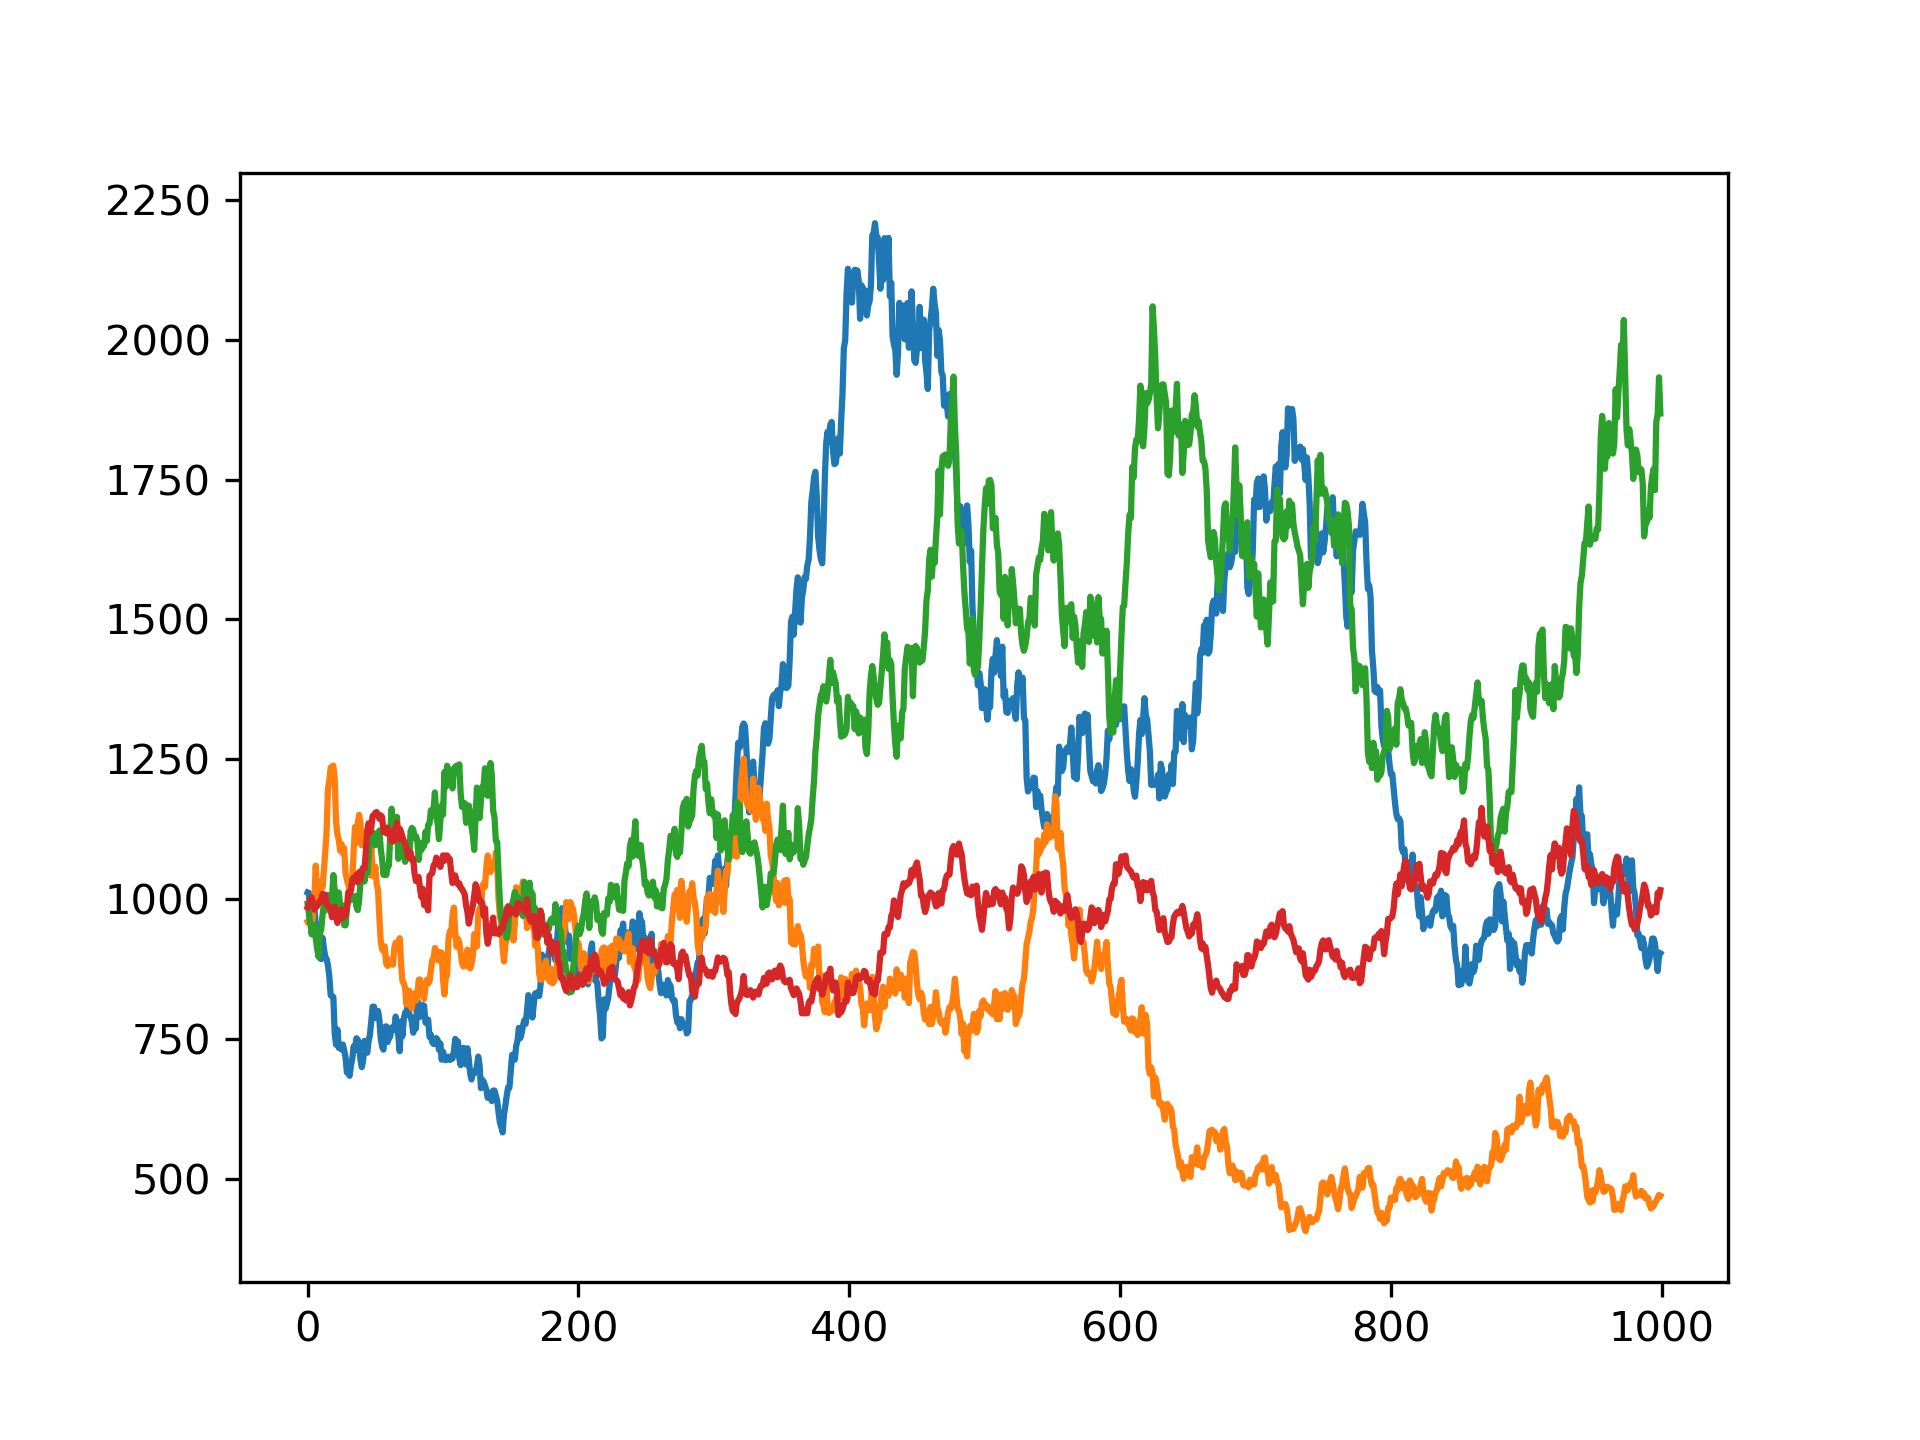

In [24]:
plt.figure(dpi=150)

plt.plot(get_GBM(1000, 1000, 0, 0.06)) # blue
plt.plot(get_GBM(1000, 1000, 0, 0.07)) # orange
plt.plot(get_GBM(1000, 1000, 0, 0.06)) # green
plt.plot(get_GBM(1000, 1000, 0, 0.02)) # red
plt.show()

#### 2 - SMD given $\mu$ and $\sigma^2$

Assume we have $\mu$ and $\sigma^2$. We implemet SMD to find the stategy that maximizes the return in the simplex of probability distributions.

We have

$$
p_\lambda(u,\theta) = \mathbb{E}\Big[ - \langle Z,u\rangle + \lambda \theta + \frac{\lambda}{1-\alpha} \lfloor \langle Z,u\rangle - \theta\rfloor_+ \Big].
$$

Hence $p_\lambda(u,\theta)$ can be estimated using the expression

$$
p_\lambda(u,\theta) \approx \frac{1}{M} \sum_{j=1}^{M} - \langle Z_j,u\rangle + \lambda \theta + \frac{\lambda}{1-\alpha} \lfloor \langle Z_j,u\rangle - \theta\rfloor_+,
$$

where $Z_j = e^{ \mu_{i} - \frac{\sigma_{i}^2}{2} + \sigma_{i} N} - 1$, $N \sim \mathcal{N}(0,1)$ and $M$ large enough.

In [25]:
def sample_Z(mu, sigma2, m):
    N = np.random.normal(0, 1, m)
    return np.exp(mu - sigma2/2 + np.sqrt(sigma2)*N)

def ReLU(x):
    return max(0, x)

M = 100

def p_lambda(lambda_, alpha, mu, sigma2, u, theta):
    m = len(u)
    res = []
    for _ in range(M):
        Z = sample_Z(mu, sigma2, m)
        res.append(-Z@u + lambda_*theta + lambda_*ReLU(Z@u - theta)/(1-alpha))
    return sum(res)/len(res)

The position in SMD at time $k$ will be denoted by a vector $X_k \in \mathbb{R}^{m+1}$, such that:

$$
X_k =
\begin{pmatrix}
U^k \\
\theta^k
\end{pmatrix},
$$

where $U^k \in \Delta_m \subset \mathbb{R}^m$ and $\theta^k \in \mathbb{R}$.

In [26]:
def define_p(lambda_, alpha, mu, sigma2):
    """
    Defines and returns the function p for given:
        - lambda
        - alpha
        - mu, sigma2
    """
    def p(X):
        u = X[:-1]
        theta = X[-1]
        return p_lambda(lambda_, alpha, mu, sigma2, u, theta)
    return p

For SMD, we need to estimate $\partial_{u} p_\lambda ( X_k )$ and $\partial_{\theta} p_\lambda ( X_k )$ using the expressions:

$$
\begin{cases}
\partial_{u} p_\lambda ( u, \theta ) \approx \big( -1 + \frac{\lambda}{1-\alpha}  \mathbb{1}_{ \scriptsize \{ \langle Z_k,u\rangle \geq \theta \}} \big) Z_k \\
\partial_{\theta} p_\lambda ( u, \theta ) \approx \lambda - \frac{\lambda}{1-\alpha} \mathbb{1}_{ \scriptsize \{ \langle Z_k',u\rangle \geq \theta \}},
\end{cases} 
$$

where $Z_k = e^{ \mu_{i} - \frac{\sigma_{i}^2}{2} + \sigma_{i} N} - 1$, $Z_k' = e^{ \mu_{i} - \frac{\sigma_{i}^2}{2} + \sigma_{i} N'} - 1$ and $N, N' \sim \mathcal{N}(0,1)$.

In [27]:
def indicator(x):
    if x:
        return 1
    return 0

def partial_u(lambda_, alpha, mu, sigma2, u, theta):
    m = len(u)
    Z = sample_Z(mu, sigma2, m)
    return (-1 + (lambda_/(1-alpha))*indicator(Z@u >= theta))*Z

def partial_theta(lambda_, alpha, mu, sigma2, u, theta):
    m = len(u)
    Z = sample_Z(mu, sigma2, m)
    return lambda_ - (lambda_/(1-alpha))*indicator(Z@u >= theta)

def define_partial_u(lambda_, alpha, mu, sigma2):
    """
    Defines and returns the partial derivative of p with respect to u for given:
        - lambda
        - alpha
        - mu, sigma2
    """
    def grad_p_u(X):
        u = X[:-1]
        theta = X[-1]
        return partial_u(lambda_, alpha, mu, sigma2, u, theta)
    return grad_p_u

def define_partial_theta(lambda_, alpha, mu, sigma2):
    """
    Defines and returns the partial derivative of p with respect to theta for given:
        - lambda
        - alpha
        - mu, sigma2
    """
    def grad_p_theta(X):
        u = X[:-1]
        theta = X[-1]
        return partial_theta(lambda_, alpha, mu, sigma2, u, theta)
    return grad_p_theta

As seen above, we have the following explicit recursive expression for $X_{k+1}$ in terms of $X_k$:

$$
X_{k+1} =
\begin{pmatrix} U^{k+1} \\ \theta^{k+1} \end{pmatrix}
=
\begin{pmatrix}
\frac{U^k e^{-\eta_{k+1} \partial_{u} p_\lambda ( U^k, \theta^k )}}{\lVert U^k e^{-\eta_{k+1} \partial_{u} p_\lambda ( U^k, \theta^k )} \rVert_1} \\
\theta^{k} - \eta_{k+1} \partial_{\theta} p_\lambda \big( U^k, \theta^k \big)
\end{pmatrix}.
$$

Now we can implement SMD using the recursive step expression.

In [28]:
def X_k_to_X_kplus1(deriv_u_val, deriv_theta_val, eta_kplus1, X_k):
    """
    SMD recursive step.
    """
    U_k = X_k[:-1]
    theta_k = X_k[-1]
    temp = U_k * np.exp(-eta_kplus1 * deriv_u_val)
    U_kplus1 = temp / sum(np.abs(temp))
    theta_kplus1 = theta_k - eta_kplus1 * deriv_theta_val
    X_kplus1 = np.append(U_kplus1, theta_kplus1)
    return X_kplus1

In [29]:
def SMD(p, grad_p_u, grad_p_theta, X_0, eta, eps, k_max):
    """
    Perform SMD recursive step until convergence, starting from X_0.
    """
    k = 0
    x = X_0
    x_tab = [x]
    p_tab = [p(x)]
    while (k == 0) or (abs(p_tab[-1]-p_tab[-2])/np.linalg.norm(x_tab[-1]-x_tab[-2]) > eps) and k < k_max:
        deriv_u_val = grad_p_u(x)
        deriv_theta_val = grad_p_theta(x)
        x = X_k_to_X_kplus1(deriv_u_val, deriv_theta_val, eta[k], x)
        x_tab.append(x)
        p_tab.append(p(x))
        k += 1
#     if k == k_max:
#         print("Reached maximum number of iterations. SMD did not converge.")
    return x_tab, p_tab

x_final =  [0.24280474 0.22778162 0.30083641 0.0873559  0.14122133 0.76525829]
p_final =  0.014432931760082613
Total number of iterations 375


<IPython.core.display.Javascript object>


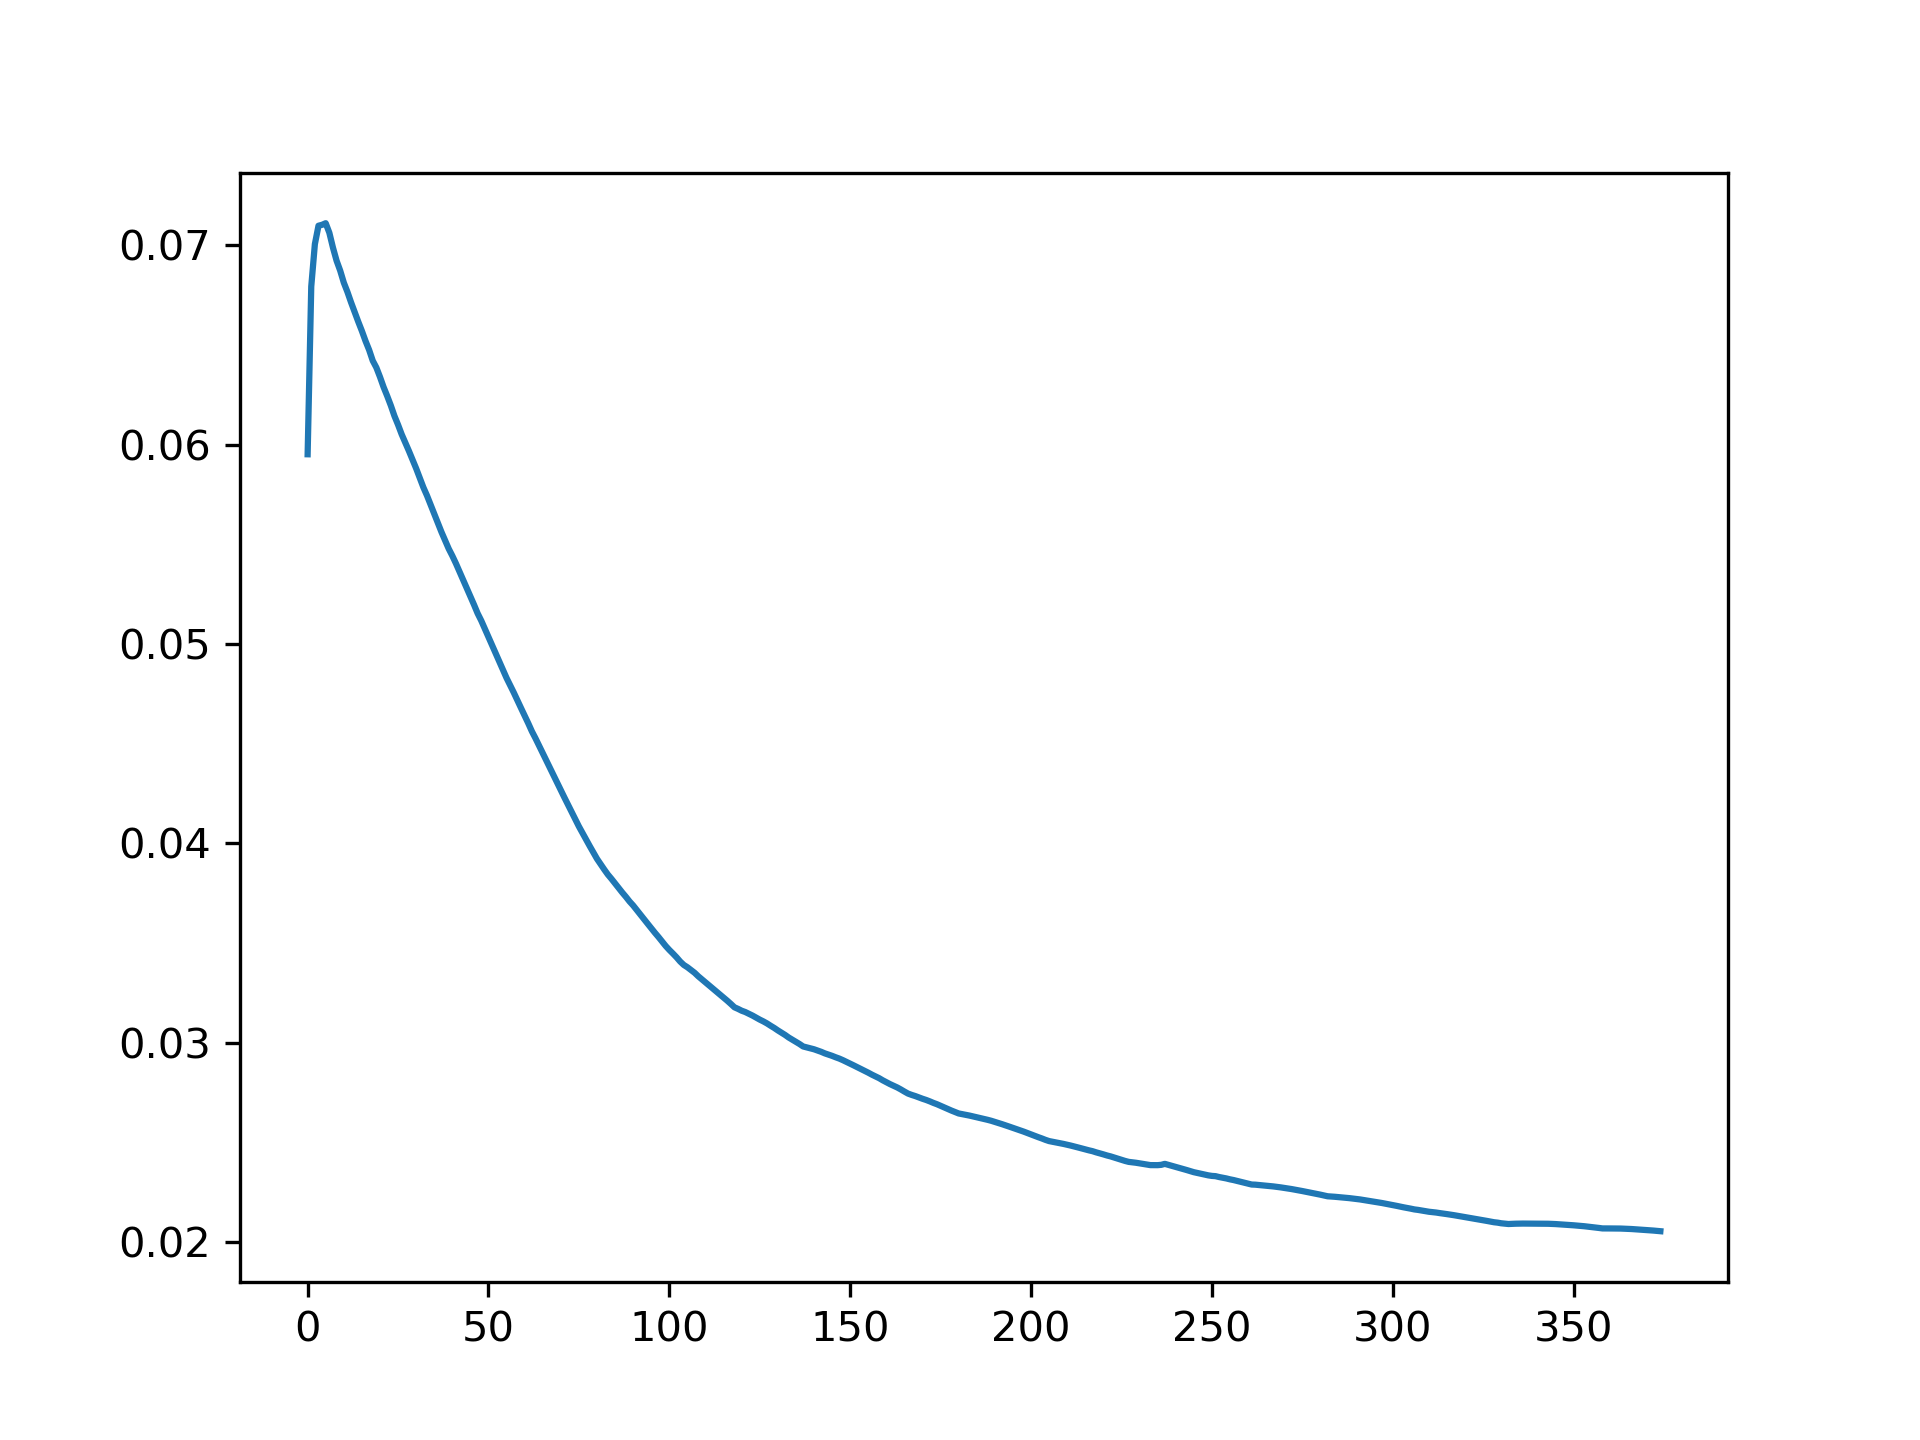

In [30]:
""" Testing SMD. """

# Set parameters of p
m = 5
lambda_ = 1
alpha = 0.05
mu = np.array([0.01, 0.02, 0.03, 0.04, 0.05])
sigma2 = np.array([0.05, 0.05, 0.005, 0.5, 0.11])

# Define p and its gradient
p = define_p(lambda_, alpha, mu, sigma2)
grad_p_u = define_partial_u(lambda_, alpha, mu, sigma2)
grad_p_theta = define_partial_theta(lambda_, alpha, mu, sigma2)

# Set SMD parameters
k_max = 10000
# eta = [1e-4  for j in range(k_max)] # step-size sequence of size >= k_max
eta = [1/np.log(j+2)  for j in range(k_max)] # step-size sequence of size >= k_max
# eta = [1/(j+1)**(0.75)  for j in range(k_max)] # step-size sequence of size >= k_max
eps = 1e-4
U_0 = np.array([1/m for _ in range(m)])
theta_0 = 1
X_0 = np.append(U_0, theta_0)
x_tab, p_tab = SMD(p, grad_p_u, grad_p_theta, X_0, eta, eps, k_max)
cum_avg_p_tab = np.cumsum(p_tab) / (np.arange(len(p_tab)) + 1)
print("x_final = ", x_tab[-1])
print("p_final = ", p_tab[-1])
#print("p_tab", p_tab)
#print("p_tab sorted", np.sort(p_tab))
print("Total number of iterations", len(p_tab))

plt.figure(dpi=150)
plt.plot(cum_avg_p_tab)
plt.show()

#### 3 - Online SMD

To perfom the online SMD, we use the algorithm seen above, which can be written as follows.

---
**Online SMD**

For $n \geq 0$, at time $t = n+1$ do:
        <ul>
            <li>observe the values of the portfolio assets $S_{n+1} = \big(S^1_{n+1}, \dots, S^m_{n+1} \big)$,</li>
            <li>compute $X_{n+1} = \big(X^1_{n+1}, \dots, X^m_{n+1} \big)$:
$$
\forall i \in \{1,\dots,m\}, \quad
X_{n+1}^i = \log{\frac{S^i_{n+1}}{S^i_n}},
$$
            </li>
            <li>compute the value of  $\hat{\theta}_{n+1} = \big(\hat{\mu}_{n+1}, \hat{\sigma}_{n+1}^2\big)$ iteratively:           
$$
\begin{cases}
\hat{\mu}_{n+1} = \frac{n}{n+1} \hat{\mu}_n - \frac{1}{2n(n+1)} \hat{\sigma}_n^2 + \frac{1}{n+1} X_{n+1} + \frac{1}{2(n+1)} \big( \hat{\mu}_n - \frac{1}{2} \hat{\sigma}_n^2 - X_{n+1} \big)^2 \\
\hat{\sigma}_{n+1}^2 =  \frac{n-1}{n} \hat{\sigma}_n^2 + \frac{1}{n+1} \big( \hat{\mu}_n - \frac{1}{2} \hat{\sigma}_n^2 - X_{n+1} \big)^2,
\end{cases}
$$               
            </li>
            <li>using SMD, set the strategy to $\omega^*\big(\hat{\theta}_{n+1}\big)$.</li>
        </ul>

---

The estimator of the parameters of the distribution of the assets at time $n$ is denoted by the vector:

$$
\hat{\theta}_{n} = \big(\hat{\mu}_{n}, \hat{\sigma}_{n}^2\big) \in \mathbb{R}^m \times \mathbb{R}^m .
$$

We start by the implementing the iterative expression of $\hat{\theta}_{n+1}$ in terms of $\hat{\theta}_{n}$ and $X_{n+1}$.

In [31]:
# Set problem parameters
m = 4
lambda_ = 0.7
alpha = 0.05

# Online method parameters
n_max = 200

# Set SMD parameters
k_max = 10000
eps = 1e-3
U_0 = np.array([1/m for _ in range(m)])
theta_0 = 1
X_0 = np.append(U_0, theta_0)


def sample_next(S_n, mu, sigma2):
    m = len(S_n)
    N = np.random.normal(0, 1, m)
    res = S_n * np.exp(mu - sigma2/2 + np.sqrt(sigma2)*N)
    return np.maximum(res, np.zeros(shape=np.shape(res))) # Asset cannot have a value less than 1

def find_optimal(mu_hat, sigma2_hat, X_prev, eta):
    # Define p and its gradient
    p = define_p(lambda_, alpha, mu_hat, sigma2_hat)
    grad_p_u = define_partial_u(lambda_, alpha, mu_hat, sigma2_hat)
    grad_p_theta = define_partial_theta(lambda_, alpha, mu_hat, sigma2_hat)
    
    # Perform descent
    x_tab, p_tab = SMD(p, grad_p_u, grad_p_theta, X_prev, eta, eps, k_max)
    
    return x_tab[-1], len(x_tab)
    

def online_method(mu, sigma2, S_1, capital):
    """
    Each day, the amount `capital` is invested.
    """
    # Initialize estimators
    mu_hat = np.ones(shape=np.shape(S_1))
    sigma2_hat = np.ones(shape=np.shape(S_1))
    mu_hat_tab = [mu_hat]
    sigma2_hat_tab = [sigma2_hat]

#     eta = [1e-3  for j in range(n_max*k_max)] # step-size sequence
    eta = [1/np.log(j+2)  for j in range(n_max*k_max)] # step-size sequence
    # eta = [1/(j+1)  for j in range(k_max)] # step-size sequence
    
    # Initialize strategy and gain to 0
    strategy = U_0
    total_gain = 0
    
    # Initialize X = (U, theta)
    X = X_0
    
    # Perform method
    n = 1
    S_n = S_1
    S_tab = [S_n]
    X_tab = []
    while n < n_max:
        # Observe values of portfolio assets
        S_nplus1 = sample_next(S_n, mu, sigma2)
        # Compute X
        X_nplus1 = np.log(S_nplus1/S_n)
        # Compute gain
        sys.stdout.write('\r')
        sys.stdout.write("[%-100s] %d%%" % ('='*((100*n)//n_max), ((100*n)//n_max)))
        sys.stdout.flush()
#         print(f'strategy: {strategy}, mu_hat: {mu_hat}, sigma2_hat: {sigma2_hat}')
        gain = capital*(strategy@(S_nplus1/S_n - 1))
        total_gain += gain
#         print(f'gain {gain}, total gain {total_gain}')
        # Update values of estimators
        mu_hat, sigma2_hat = iterative_step(mu_hat, sigma2_hat, X_nplus1, n)
        # Find optimal stategy
        X, n_it = find_optimal(mu_hat, sigma2_hat, X, eta)
        # Update step sizes
        eta = eta[n_it:]
        strategy = X[:-1]
        mu_hat_tab.append(mu_hat)
        sigma2_hat_tab.append(sigma2_hat)
        n += 1
        S_n = S_nplus1
        S_tab.append(S_n)
        X_tab.append(X_nplus1)
#         print(f'\n')
    print("\n", strategy)
    print("Final Strategy", strategy)
    print("mu", mu)
    print("mu_hat", mu_hat_tab[-1])
    print("sigma2", sigma2)
    print("sigma2_hat", sigma2_hat_tab[-1])
    print("Final portfolio return:", total_gain)
    
    mu_hat_tab = mu_hat_tab[5:]
    sigma2_hat_tab = sigma2_hat_tab[5:]
    fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(9, 8))
    for i in range(len(mu)):
        mu_i = np.array([mu_hat_tab[j][i] for j in range(len(mu_hat_tab))])
        mu_cst = np.array([mu[i] for _ in range(len(mu_hat_tab))])
        axs[0, 0].plot(mu_i, label='$\hat{\mu}' + f'_{i}$')
        axs[0, 0].plot(mu_cst, label='$\mu' + f'_{i}$')
        axs[0, 1].loglog(np.abs((mu_i - mu_cst)), label='$|\mu' + f'_{i}-' + '\hat{\mu}' + f'_{i}|$')
        sigma2_i = np.array([sigma2_hat_tab[j][i] for j in range(len(sigma2_hat_tab))])
        sigma2_cst = np.array([sigma2[i] for _ in range(len(sigma2_hat_tab))])
        sigma2_err = np.cumsum(p_tab) / (np.arange(len(p_tab)) + 1)
        axs[1, 0].plot(sigma2_i, label='$\hat{\sigma}^2' + f'_{i}$')
        axs[1, 0].plot([sigma2[i] for _ in range(len(sigma2_hat_tab))], label='$\sigma^2' + f'_{i}$')
        axs[1, 1].loglog(np.abs(sigma2_i - sigma2_cst), label='$|\sigma^2' + f'_{i}-' + '\hat{\sigma}^2' + f'_{i}|$')
    axs[0, 1].loglog(np.arange(1, len(mu_hat_tab)), np.array([1/d for d in range(1, len(mu_hat_tab))]), label='$1/n$', color='black')
    axs[1, 1].loglog(np.arange(1, len(mu_hat_tab)), np.array([1/d for d in range(1, len(mu_hat_tab))]), label='$1/n$', color='black')
    axs[0, 0].set_title('Convergence of $\hat{\mu}_n$')
    axs[0, 0].set_xlabel('time ($n$)')
    axs[0, 0].set_ylabel('$\hat{\mu}_n$, $\mu$')
    axs[0, 1].set_title('Error $|\hat{\mu}_n - \mu|$')
    axs[0, 1].set_xlabel('time ($n$)')
    axs[0, 1].set_ylabel('$|\hat{\mu}_n - \sigma^2|$')
    axs[1, 0].set_title('Convergence of $\hat{\sigma}^2_n$')
    axs[1, 0].set_xlabel('time ($n$)')
    axs[1, 0].set_ylabel('$\hat{\sigma}^2_n$, $\sigma^2$')
    axs[1, 1].set_title('Error $|\hat{\sigma}^2_n - \sigma^2|$')
    axs[1, 1].set_xlabel('time ($n$)')
    axs[1, 1].set_ylabel('$|\hat{\sigma}^2_n - \sigma^2|$')
    axs[0, 0].legend()
    axs[0, 1].legend()
    axs[1, 0].legend()
    axs[1, 1].legend()
    plt.show()

[=================================================================================================== ] 99%
 [1.0e+000 2.2e-322 4.9e-323 4.0e-323]
Final Strategy [1.0e+000 2.2e-322 4.9e-323 4.0e-323]
mu [ 0.15   0.03  -0.07  -0.133]
mu_hat [ 0.15030557  0.02103517 -0.09160584 -0.13666071]
sigma2 [0.025 0.015 0.02  0.03 ]
sigma2_hat [0.02450229 0.01545711 0.02153467 0.03630986]
Final portfolio return: 3152.973936936404


<IPython.core.display.Javascript object>


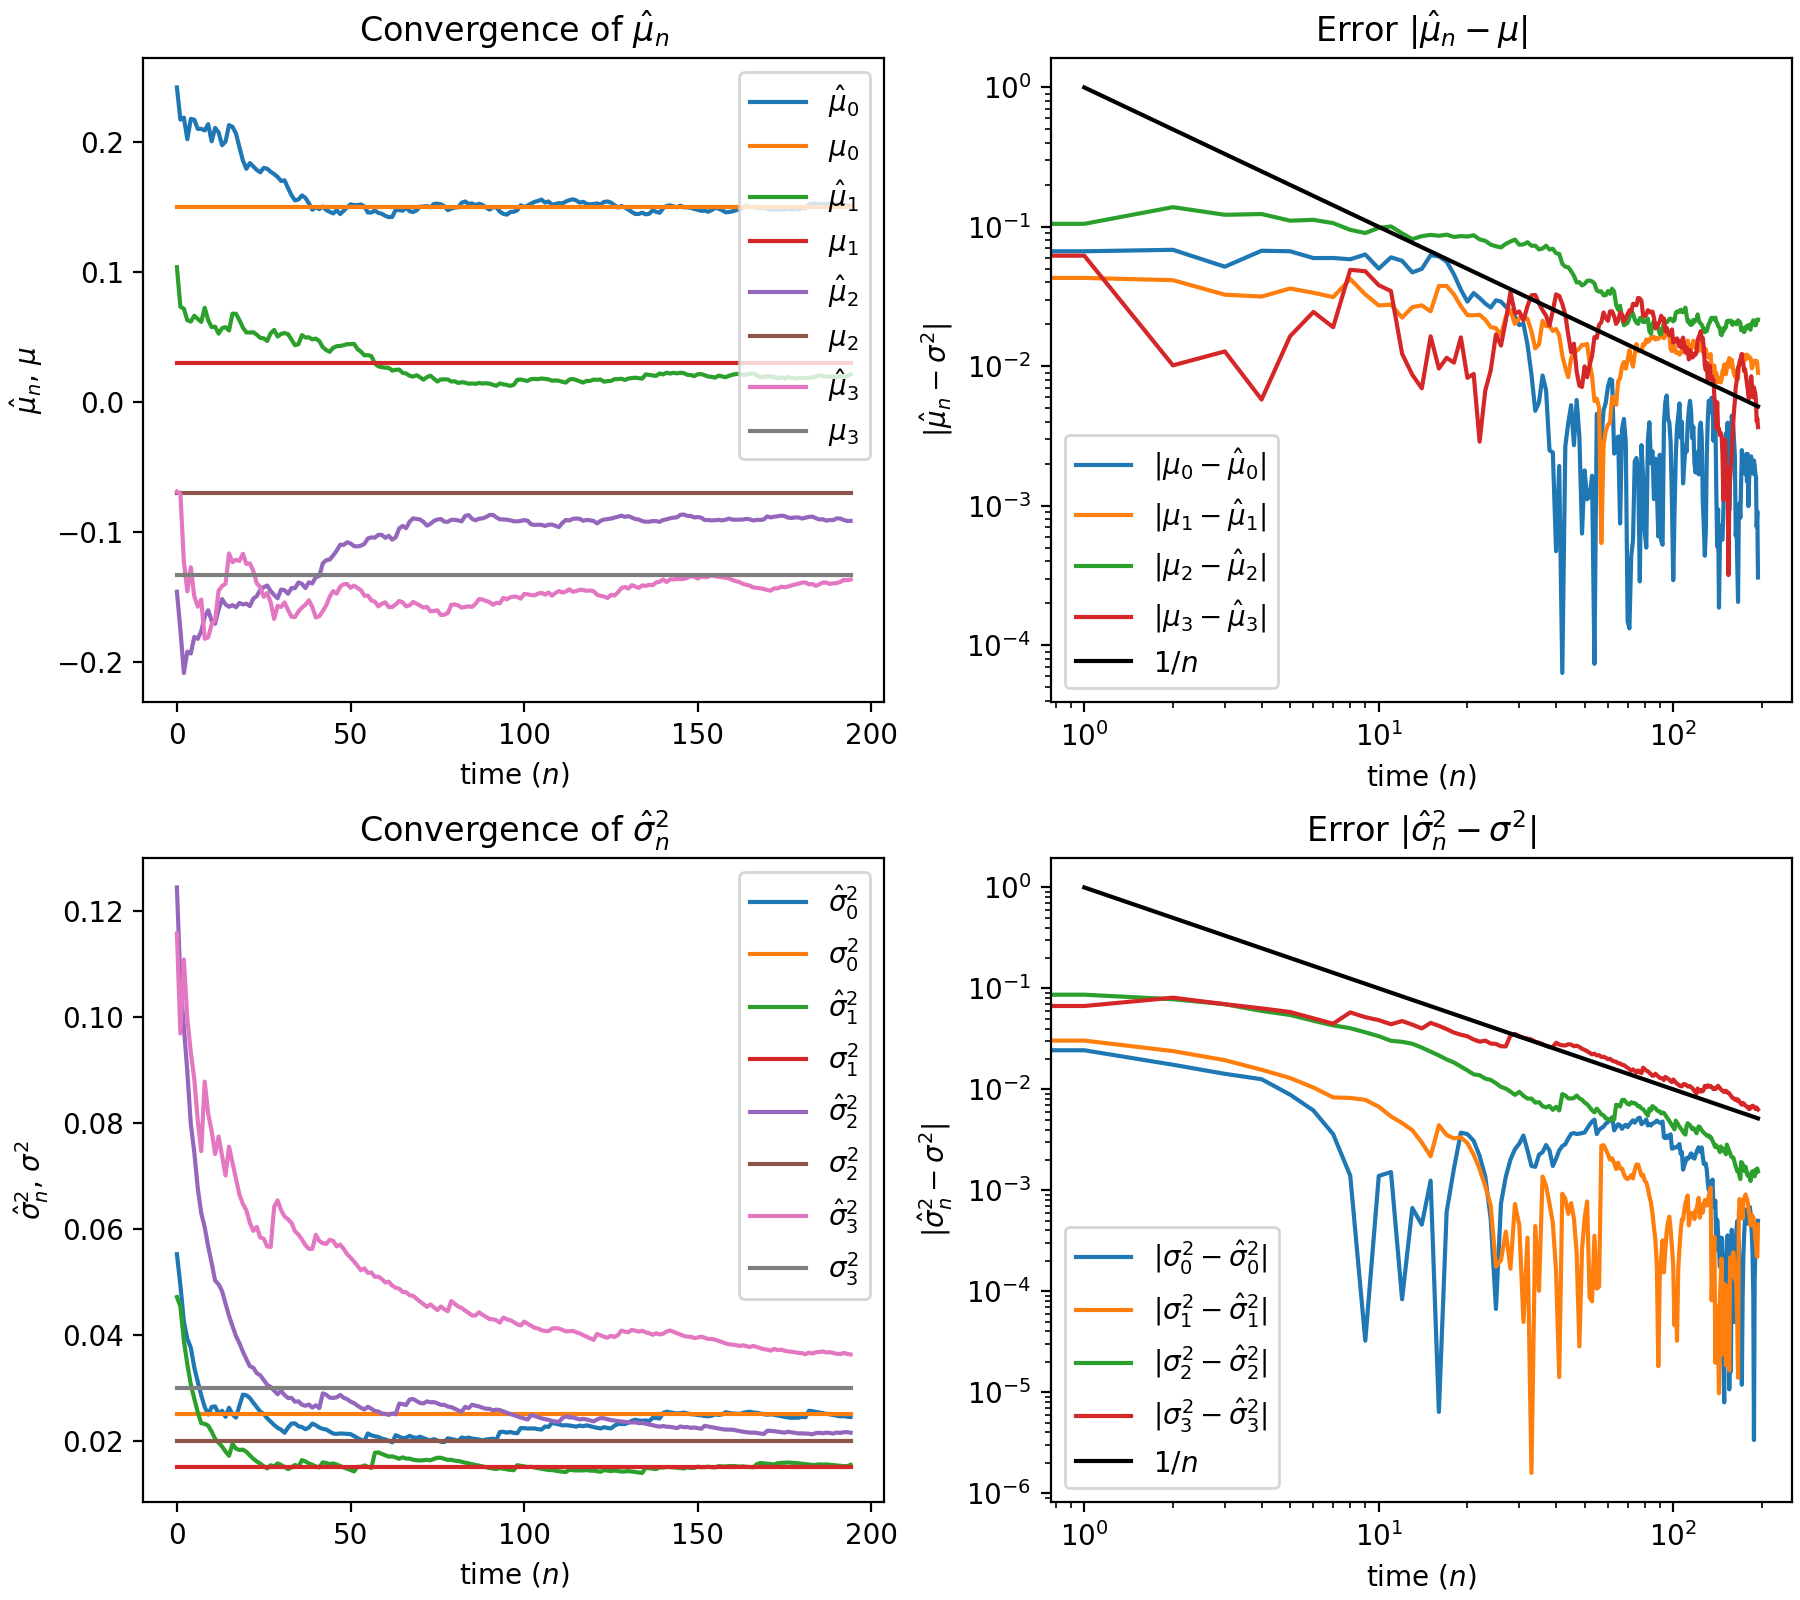

In [32]:
online_method(mu=np.array([0.15, 0.03, -0.07, -0.133]), sigma2=np.array([0.025, 0.015, 0.02, 0.03]), S_1=np.array([1000, 1000, 1000, 1000]), capital=100)

# Appendices

## A - Expression of the inverse of the gradient of entropy $\big(\nabla \phi\big)^{-1}$

We want to find the expression of the inverse of the gradient of the entropy function $\big(\nabla \phi\big)^{-1}$ over the simplex $\Delta_{m}$ of probability distributions.

We have:

$$
\forall u \in \Delta_m, \quad \phi(u) = \sum_{i=1}^{m} u_i \log{u_i},
$$

then:

$$
\forall u \in \Delta_m, \quad \nabla \phi(u) = \big(1+\log{u_1},\dots,1+\log{u_m}\big) = \big(1+\log{u_i}\big)_{1 \leq i \leq m}.
$$

We know that:

$$
u = e^{(\log{u_i})_{1 \leq i \leq m}}.
$$

Hence

$$
u = e^{\nabla \phi(u) - \mathbb{1}},
$$

where $\mathbb{1} = (1,\dots,1) = (1)_{1 \leq i \leq m}$.

Hence,

$$
\forall v \in \im{\big(\nabla \phi\big)}, \quad \big(\nabla \phi\big)^{-1}(v) = e^{v - \mathbb{1}}.
$$

## B - Iterative expression for empirical mean and empirical variance

Let's denote by $\alpha_n$ and $\beta_n$ respectively the empirical mean and empirical variance of our sample, that is:

$$
\begin{cases}
\alpha_n = \bar{X}_n = \hat{\mu}_n - \frac{1}{2} \hat{\sigma}_n^2 \\
\beta_n = \frac{1}{n-1} \sum_{j = 1}^{n} \big(X_j - \bar{X}_n\big)^2 = \hat{\sigma}_n^2
\end{cases}
$$

Then we can get an iterative expression of $\alpha_n$ and $\beta_n$ given by:

$$
\begin{cases}
\alpha_{n+1} = \frac{n}{n+1} \alpha_{n} + \frac{1}{n+1} X_{n+1} \\
\beta_{n+1} = \frac{n-1}{n}\beta_n + \frac{1}{n+1} \big( \alpha_{n} - X_{n+1} \big)^2
\end{cases}
$$

<i>Proof:</i>

We have:

$$
\begin{cases}
\alpha_n = \bar{X}_n \\
\beta_n = \frac{1}{n-1} \sum_{j = 1}^{n} \big(X_j - \bar{X}_n\big)^2 = \frac{1}{n-1} \sum_{j=1}^{n} X_j^2 - \frac{n}{n-1} \bar{X}_n^2
\end{cases}
$$

From the first equality, we get:

$$
(n+1)\alpha_{n+1} = n\alpha_{n} + X_{n+1}
$$


which gives:

$$
\alpha_{n+1} = \frac{n}{n+1} \alpha_{n} + \frac{1}{n+1} X_{n+1}
$$

And from the second equality, we get:

$$
n\Big(\beta_{n+1}+\frac{n+1}{n}\bar{X}_{n+1}^2\Big) = (n-1)\Big(\beta_{n}+\frac{n}{n-1}\bar{X}_{n}^2\Big) + X_{n+1}^2
$$

hence:

$$
\begin{align}
\beta_{n+1} &= \frac{n-1}{n}\beta_n + \bar{X}_n^2 + \frac{1}{n} X^2_{n+1} - \frac{n+1}{n} \bar{X}_{n+1}^2 \\
&= \frac{n-1}{n}\beta_n + \alpha_n^2 - \frac{n+1}{n} \alpha_{n+1}^2 + \frac{1}{n} X^2_{n+1} \\
&= \frac{n-1}{n}\beta_n + \alpha_n^2 - \frac{n+1}{n} \Big(\frac{n}{n+1} \alpha_{n} + \frac{1}{n+1} X_{n+1}\Big)^2 + \frac{1}{n} X^2_{n+1} \\
&= \frac{n-1}{n}\beta_n + \alpha_n^2 - \frac{n}{n+1} \alpha_{n}^2 - \frac{2}{n+1} \alpha_n X_{n+1} - \frac{1}{n(n+1)} X^2_{n+1} + \frac{1}{n} X^2_{n+1} \\
&= \frac{n-1}{n}\beta_n + \frac{1}{n+1} \alpha_{n}^2 - \frac{2}{n+1} \alpha_n X_{n+1} + \frac{1}{n+1} X^2_{n+1} \\
&= \frac{n-1}{n}\beta_n + \frac{1}{n+1} \big( \alpha_{n} - X_{n+1} \big)^2
\end{align}
$$

Therefore, we get

$$
\begin{cases}
\alpha_{n+1} = \frac{n}{n+1} \alpha_{n} + \frac{1}{n+1} X_{n+1} \\
\beta_{n+1} = \frac{n-1}{n}\beta_n + \frac{1}{n+1} \big( \alpha_{n} - X_{n+1} \big)^2
\end{cases}
$$

<i>End of Proof.</i>

Now let's find the iterative expressions of $\hat{\mu}_n$ and $\hat{\sigma}_n^2$. We have:

$$
\begin{cases}
\alpha_n = \hat{\mu}_n - \frac{1}{2} \hat{\sigma}_n^2 \\
\beta_n = \hat{\sigma}_n^2
\end{cases}
$$

Then:

$$
\begin{cases}
\hat{\mu}_n = \alpha_n + \frac{1}{2} \beta_n \\
\hat{\sigma}_n^2 = \beta_n
\end{cases}
$$

Hence:

$$
\begin{cases}
\alpha_{n+1} = \frac{n}{n+1} \hat{\mu}_n - \frac{n}{2(n+1)} \hat{\sigma}_n^2 + \frac{1}{n+1} X_{n+1} \\
\beta_{n+1} = \frac{n-1}{n} \hat{\sigma}_n^2 + \frac{1}{n+1} \big( \hat{\mu}_n - \frac{1}{2} \hat{\sigma}_n^2 - X_{n+1} \big)^2
\end{cases}
$$

Therefore:

$$
\begin{cases}
\hat{\mu}_{n+1} = \alpha_{n+1} + \frac{1}{2} \beta_{n+1} = \frac{n}{n+1} \hat{\mu}_n - \frac{n}{2(n+1)} \hat{\sigma}_n^2 + \frac{1}{n+1} X_{n+1} + \frac{1}{2} \Big( \frac{n-1}{n} \hat{\sigma}_n^2 + \frac{1}{n+1} \big( \hat{\mu}_n - \frac{1}{2} \hat{\sigma}_n^2 - X_{n+1} \big)^2 \Big) \\
\hat{\sigma}_{n+1}^2 = \beta_{n+1} = \frac{n-1}{n} \hat{\sigma}_n^2 + \frac{1}{n+1} \big( \hat{\mu}_n - \frac{1}{2} \hat{\sigma}_n^2 - X_{n+1} \big)^2
\end{cases}
$$

Which simplifies to:

$$
\begin{cases}
\hat{\mu}_{n+1} = \frac{n}{n+1} \hat{\mu}_n - \frac{1}{2n(n+1)} \hat{\sigma}_n^2 + \frac{1}{n+1} X_{n+1} + \frac{1}{2(n+1)} \big( \hat{\mu}_n - \frac{1}{2} \hat{\sigma}_n^2 - X_{n+1} \big)^2 \\
\hat{\sigma}_{n+1}^2 =  \frac{n-1}{n} \hat{\sigma}_n^2 + \frac{1}{n+1} \big( \hat{\mu}_n - \frac{1}{2} \hat{\sigma}_n^2 - X_{n+1} \big)^2
\end{cases}
$$